In [1]:
""" Imports """

import uproot
import numpy as np
import pandas as pd
import glob
import os
import h5py
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from decimal import *
from pathlib import Path


""" Global variables """

save_folder_global = 'Synchronisation' # Processed data from will be stored in a folder named like this. 
raw_data_folder_global = '/eos/home-s/spigazzi/Lab21/data/Reco/' # Raw data is stored here
plot_save_folder_global = 'Variation Stats ' # Produced plots are saved here

# useful for the gaussian fit
def gaussian(x, *p):
    A, mu, sigma = p
    return A * np.exp(-(x -mu)**2/(2*sigma**2))

""" Parent Class definition """

# TODO: check consistency of the different runs (same boards), raise error if not consistent
class ECAL:
    def __init__(self, included_runs, letters, 
                 save_folder = save_folder_global, raw_data_folder = raw_data_folder_global, 
                 plot_save_folder = plot_save_folder_global):
        """
        included_runs -- (list) run numbers (int) to be analysed
        letters -- (list) of letters (strings) corresponding to the boards connected
        save_folder -- (string) folder where the computed data should be stored
        raw_data_folder -- (string) folder where the raw experiment data is located
        plot_save_folder -- (string) folder where the plots are saved
        """
        
        self.save_folder = save_folder
        self.raw_data_folder = raw_data_folder
        self.plot_save_folder = plot_save_folder
        
        self.split_name = 'Merged' 
        # Needed for legacy support, namely to be able to run the statistics_plot and variation plot functions 
        # on the data files from January 2022 with 'Merged in their name'. 
        # Obsolete otherwise, split_name could be removed everywhere 

        self.numbers = ['1', '2', '3', '4', '5'] # The five channels on each board
        self.included_runs = included_runs # all runs to be processed
        self.letters = letters
        
        # for colormesh plots
        self.X = self.numbers.copy(); self.X.insert(0, '0')
        self.Y = self.letters.copy(); self.Y.insert(0, '0')

        # define channel_names, the access to the 'mesh' with the letters and the numbers
        self.channel_names = []
        for letter in self.letters:
            channel_names_temp = [letter + n for n in self.numbers]
            self.channel_names += channel_names_temp

        
""" 1st Child Class definition """

class Amplitude(ECAL):
    """
    This class is for the analysis of the amplitudes
    """
    def __init__(self, included_runs, letters, # TODO: check if h5 file generated for the runs
                 save_folder = save_folder_global, raw_data_folder = raw_data_folder_global,
                 plot_save_folder = plot_save_folder_global):
        super().__init__(included_runs, letters, save_folder, raw_data_folder, plot_save_folder) 

    # TODO: should be private / shouldn't be accessed from outside
    def run_amplitude_single_run(self, run_number):
        """ 
        Computes the amplitude for a single run. 
        The splits are merged into a single big run number and the time deltas are saved in an h5 file.
    
        run_number -- (string or int) the number of a run, for example '15610'
        """
    
        # Computation with merged data
        folder =  self.raw_data_folder + str(int(run_number))
        h = uproot.concatenate({folder + '/*.root' : 'digi'}, allow_missing = True)
    
        run_name = os.path.basename(os.path.normpath(folder))
        print('Run: ', run_name, ' Split: ', self.split_name)
        run_save = self.save_folder + '/Run ' + run_name + '/' + self.split_name + '/'
        Path(run_save).mkdir(parents=True, exist_ok=True)

        amp = h['amp_max'] # retrieve the amplitude
        amp_pd = pd.DataFrame(amp)
    
        # 'empty' arrays to store the statistics of each channel
        mu_arr = np.zeros(len(self.channel_names))
        mu_error_arr = np.zeros(len(self.channel_names))
        sigma_arr = np.zeros(len(self.channel_names))
        sigma_error_arr = np.zeros(len(self.channel_names))
    
        for i in range(len(self.channel_names)):
            plt.figure()
            border_size = 2000

            hist, bin_edges, _ = plt.hist(amp_pd[i], bins = 1500, label= 'Amplitude Histogram')
            bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)  
        
            # fitting process
            guess = [np.max(hist), bin_centers[np.argmax(hist)], 300]
            coeff, covar = curve_fit(gaussian, bin_centers, hist, p0=guess)
            mu = coeff[1]
            mu_error = covar[1,1]
            sigma = coeff[2]
            sigma_error = covar[2,2]
            mu_arr[i] = mu
            mu_error_arr[i] = mu_error
            sigma_arr[i] = sigma
            sigma_error_arr[i] = sigma_error
        
            # TODO: put correct units for amplitude
            # plotting the histogram with a gaussian fit, the mean and the standard deviation
            plt.plot(bin_centers, gaussian(bin_centers, *coeff), label='Gaussian Fit')
            plt.axvline(mu, label = f'Mean: {np.around(mu, decimals = 1)} ??', color = 'red')
            sigma_color = 'pink'
            plt.axvline(mu + sigma, label = f'Std Dev: {np.around(sigma, decimals = 1)} ??', color = sigma_color)
            plt.axvline(mu - sigma, color = sigma_color)
        
            plt.title(f'Run: {run_name}, Channel: {self.channel_names[i]}')
            plt.xlabel('Amplitude (??)')
            plt.ylabel('Occurence (a.u.)')
            plt.legend(loc='best')
            
            plt.show()
        
        # saving the statistics in a file for later use, eg. in statistics_plot
        statistics = np.hstack((mu_arr.reshape(-1,1), mu_error_arr.reshape(-1,1), 
                                sigma_arr.reshape(-1,1), sigma_error_arr.reshape(-1,1)))
        
        with h5py.File(run_save + 'Statistics Split ' + self.split_name + '.h5', 'w') as hf:
            hf.create_dataset("stats",  data=statistics)
        

    # TODO: faire en sorte qu'une liste appelle mutliple et un entier seul appelle single
    def run_amplitude(self):
        """
        Plots the histogram for every single run in the included_runs list (parent attribute)
        """
        for single_run in self.included_runs:
            self.run_amplitude_single_run(single_run)
        print('-- Histogram plot(s) finished --')

    
    def run_statistics_single_run(self, run_number):
        """ 
        Plots mu and sigma as well as their errors for the amplitude of a designated single run in a colormesh plot.
        One has to have run the run_amplitude_computation function on the designated run first before using this function.
    
        run_number -- (string or int) The number of a run, for example '15484'
        save_folder -- (string) Folder where the computed data should be stored
        raw_data_folder -- (string) Folder where the raw experiment data is located
        skip_mu == (boolean) If one is not interested in mu, one can skip plotting it
        """
    
        stat_names = ['Mu', 'Mu error', 'Sigma', 'Sigma_error']
        folder =  self.raw_data_folder + str(int(run_number))
        run_name = os.path.basename(os.path.normpath(folder))
        print('Run: ', run_name, ' Split: ', self.split_name)
        run_save = self.save_folder + '/Run ' + str(run_name) + '/' + self.split_name + '/'
        Path(run_save).mkdir(parents=True, exist_ok=True)

        with h5py.File(run_save + 'Statistics Split ' + self.split_name + '.h5', 'r') as hf:
            statistics = hf[f"stats"][:]

        for i in range(len(statistics[0,:])):
            plt.figure()
            stat_data = statistics[:,i].reshape(len(self.letters), len(self.numbers))
            c = plt.pcolormesh(self.X, self.Y, stat_data)
            cb = plt.colorbar(c)
            cb.set_label('Max amplitude over Channels (??)')
            plt.title(f'{stat_names[i]}, Run: {run_name}, Split: {self.split_name}')
            plt.show()
        
        plt.savefig(run_save + f'Stats Colormesh.pdf', dpi = 300)

        
    def run_statistics(self):
        """
        Plots the colormesh map for every single run in the included_runs list (parent attribute)
        """
        for single_run in self.included_runs:
            self.run_statistics_single_run(single_run)
        print('-- Colormesh plot(s) finished --')
        
    
    # TODO: write similar function to analyse the evolution(spills) for a single run
    # TODO: test with a specific reference channel
    # TODO: lancer une exception lorsque liste contient un seul run (pas d'évolution possible)
    def variation_plot_runs(self, specific_ref_channel='all'):
        """
        Plots the evolution of the mu and sigma statistics and their errors over a number of runs.
    
        measurement_name -- (string) Title of the measurement, for example power cycle or temperature
        measurement_date -- (string) Date of the measurement. Originally used to distinguish between series of runs, 
                            but the date will not be unique enough for future measurements.
                            Could and should be replaced by a unique identifier, like an ID for a batch of runs.
        included_runs -- (list of strings or ints) List of all the runs to include in our variation plot.
        specific_ref_channel -- (string) If one wants to test the function only for a specific channel, use that channel here, for example 'B3'
        """
    
        for k, run_name in enumerate(self.included_runs):
            run_save = self.save_folder + '/Run ' + str(run_name) + '/' + self.split_name + '/'
            if k==0: # create the stacked_average_stats first
                with h5py.File(run_save + 'Statistics Split ' + self.split_name + '.h5', 'r') as hf:
                    stacked_average_stats = hf[f"stats"][:]
            else: # then stack for each run included
                with h5py.File(run_save + 'Statistics Split ' + self.split_name + '.h5', 'r') as hf:
                    stacked_average_stats = np.dstack((stacked_average_stats, hf[f"stats"][:]))            
            # stacked_average_stats has shape (n_channels, n_stats, n_runs)
    
        # TODO: exception pour ce genre de pb
        # now select a particular channel if given in specific_ref_channel
        if specific_ref_channel != 'all':
            if (specific_ref_channel not in self.channel_names):
                print('specified channel given not in list, no particular channel selected')
            else:
                index = np.where(channel_names == specific_ref_channel)
                stacked_average_stats = stacked_average_stats[index[0][0],:,:]
    
        for i, board in enumerate(self.letters): # one plot per board letter 'A', ...
            plt.figure()
        
            # one line plotted per channel 1, ..., 5 in each board
            for j, nb in enumerate(self.numbers):
                plt.errorbar(np.arange(len(self.included_runs)), stacked_average_stats[(5*i)+j,0,:], yerr=stacked_average_stats[(5*i)+j,2,:], label=self.channel_names[(5*i)+j])
                plt.xticks(np.arange(len(self.included_runs)), self.included_runs)
            
            plt.legend(loc='best')
            plt.title(f'Board {board}, mean amplitude over runs')
            plt.xlabel('Run')
            plt.ylabel('Amplitude (??)')
            plt.show()
       
       
""" 2nd Child Class definition """     
        
class Time(ECAL):
    """
    This class is for the analysis of the time resolution of the detector
    """
    def __init__(self, included_runs, letters, # TODO: check if h5 file generated for the runs
                 save_folder = save_folder_global, raw_data_folder = raw_data_folder_global,
                 plot_save_folder = plot_save_folder_global):
         super().__init__(included_runs, letters, save_folder, raw_data_folder, plot_save_folder)
    
    
    def synchroniser(self, value):
        """ Function to remove the period shift. Collects the scattered peaks separated by integer multiples of the clock period to one large peak """
        clock_period = 6.238 # nanoseconds    
        window_leniency = 0.5 # How far from the center value the synchroniser should start to act. Minimum Value that makes sense physically: 0.5
        if value > 0:
            while value > clock_period * window_leniency:
                value -= clock_period
        else:
            while value < (-clock_period * window_leniency):
                value += clock_period
        return float(Decimal(value) % Decimal(clock_period))
    
    
    def temperature_conversion(self, resistance):
        """ Takes resistance in Ohm. Returns temperature calculated from the measured resistance of the temperature sensor reader """
        nominal_resistance = 1000 # in Ohm
        mean_coefficient = 3.91e-3 # in K^-1, for the plantinum resistance thermometer Pt1000
        return (np.abs(resistance - nominal_resistance))/(mean_coefficient * nominal_resistance)
    
    
    def to_channel_converter(self, channel_number):
        """ Converts the channel number to the appropriate Channel. For example 7 -> 'B3'. """
        board_counter = 0
        while channel_number > 4:
            board_counter += 1
            channel_number -= 5
        return f'{self.letters[board_counter]}{self.numbers[channel_number]}'
    
    
    def compute_time_delta(self, time, reference_channel_index, run_name, plot=True, apply_synchroniser=True):
        """ Computes the time difference (delta) for a given reference channel to all the other channels. 
        Also returns the mu and sigma statistics and their errors."""
        time_pd = pd.DataFrame(time)
        n_channels = len(self.channel_names)

        time_delta_pd = pd.DataFrame()
        mu_arr = np.zeros(n_channels)
        mu_error_arr = np.zeros(n_channels)
        sigma_arr = np.zeros(n_channels)
        sigma_error_arr = np.zeros(n_channels)
        for i in range(n_channels):
            if i == reference_channel_index:
                continue

            reference_time = time_pd.iloc[:,reference_channel_index]
            curr_time = time_pd.iloc[:,i]
            time_delta = reference_time - curr_time

            # Remove period shift from the data
            if apply_synchroniser: 
                time_delta = time_delta.apply(self.synchroniser)

            time_delta = time_delta.multiply(1000)

            # Save time deltas for later analysis
            time_delta_pd[f'{i}'] = time_delta

            plt.figure()
            border_size = 2000
            plt.xlim((-border_size,border_size))

            # The fitting process
            hist, bin_edges, _ = plt.hist(time_delta, bins = 1500, label='Time Delta Histogram')
            bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)  
            guess = [np.max(hist), bin_centers[np.argmax(hist)], 300]
            coeff, covar = curve_fit(gaussian, bin_centers, hist, p0=guess)
            mu = coeff[1]
            mu_error = covar[1,1]
            sigma = coeff[2]
            sigma_error = covar[2,2]
            mu_arr[i] = mu
            mu_error_arr[i] = mu_error
            sigma_arr[i] = sigma
            sigma_error_arr[i] = sigma_error

            if plot:
                plt.plot(bin_centers, gaussian(bin_centers, *coeff), label='Gaussian Fit')
                plt.axvline(mu, label = f'Mean: {np.around(mu, decimals = 1)} ps', color = 'red')
                sigma_color = 'pink'
                plt.axvline(mu + sigma, label = f'Std Dev: {np.around(sigma, decimals = 1)} ps', color = sigma_color)
                plt.axvline(mu - sigma, color = sigma_color)
                plt.title(f'Reference Channel: {self.to_channel_converter(reference_channel_index)}, Run: {run_name}, Channel {self.to_channel_converter(i)}')
                plt.xlabel('Time Delta (ps)')
                plt.ylabel('Occurence (a.u.)')
                plt.legend(loc='best')

        plt.show()

        return time_delta_pd, mu_arr.reshape(-1,1), mu_error_arr.reshape(-1,1), sigma_arr.reshape(-1,1), sigma_error_arr.reshape(-1,1)
    

    def run_time_delta_computation_single_run(self, run_number):
        """ 
        Computes the time deltas for a single run. 
        The splits are merged into a single big run number and the time deltas are saved in an h5 file.

        run_number -- (string or int) the number of a run, for example '15610'
        """

        # Computation with merged data
        folder =  self.raw_data_folder + str(int(run_number))
        h = uproot.concatenate({folder+'/*.root' : 'digi'}, allow_missing = True)

        run_name = os.path.basename(os.path.normpath(folder))
        print('Run: ', run_name, ' Split: ', self.split_name)
        run_save = self.save_folder + '/Run ' + run_name + '/' + self.split_name + '/'
        Path(run_save).mkdir(parents=True, exist_ok=True)

        for ref_channel in self.channel_names:       
            ref_idx = h[ref_channel][0]
            time = h['time_max']
            time_pd = pd.DataFrame(time)

            time_delta_data, mu_arr, mu_error_arr, sigma_arr, sigma_error_arr  = self.compute_time_delta(time, ref_idx, run_name)
            statistics = np.hstack((mu_arr, mu_error_arr, sigma_arr, sigma_error_arr))
            time_delta_data.to_hdf(run_save + f'Time Delta Run {run_name} ref_ch {ref_channel}.h5', key='df', mode='w')
            with h5py.File(run_save + 'Statistics Split ' + self.split_name + f' ref_ch {ref_channel}.h5', 'w') as hf:
                hf.create_dataset("stats",  data=statistics)
                
    def run_time_delta(self):
        """
        Plots the time delta histogram for every single run in the included_runs list (parent attribute)
        """
        for single_run in self.included_runs:
            self.run_time_delta_computation_single_run(single_run)
        
    # TODO: avoid implicit dependence the previous one to get the statistics, hence check if h5 file exists    
    def statistics_plot_single_run(self, run_number, skip_mu=False):
        """ 
        Plots mu and sigma as well as their errors for the time deltas of a designated run in a colormesh plot.
        One has to have run the run_time_delta_computation function on the designated run first before using this function.

        run_number -- (string or int) The number of a run, for example '15484'
        skip_mu == (boolean) If one is not interested in mu, one can skip plotting it
        """

        stat_names = ['Mu', 'Mu error', 'Sigma', 'Sigma_error']
        folder =  self.raw_data_folder + str(int(run_number))
        run_name = os.path.basename(os.path.normpath(folder))
        print('Run: ', run_name, ' Split: ', self.split_name)
        run_save = self.save_folder + '/Run ' + str(run_name) + '/' + self.split_name + '/'
        Path(run_save).mkdir(parents=True, exist_ok=True)

        for k, ref_channel in enumerate(self.channel_names):
            with h5py.File(run_save + 'Statistics Split ' + self.split_name + f' ref_ch {ref_channel}.h5', 'r') as hf:
                statistics = hf[f"stats"][:]

            for i in range(len(statistics[0,:])):
                if skip_mu and ((i == 0) or (i ==1)):
                    continue

                plt.figure()
                stat_data = statistics[:,i].reshape(len(stat_names),len(self.numbers))
                c = plt.pcolormesh(self.X, self.Y, stat_data*1000)
                cb = plt.colorbar(c)
                cb.set_label('Deviation over Channels (ps)')
                plt.title(f'{stat_names[i]}, Run: {run_name}, Split: {self.split_name}, Reference Channel: {ref_channel}')
                plt.show()
            plt.savefig(run_save + f'Stats Colormesh Ref Channel {self.to_channel_converter(k)}.pdf', dpi = 300)
    
    def run_statistics(self, skip_mu=False):
        """
        Plots the colormesh map for every single run in the included_runs list (parent attribute)
        """
        for single_run in self.included_runs:
            self.statistics_plot_single_run(single_run, skip_mu)
    
    # TODO: check if works ok
    def variation_plot(self, measurement_name, measurement_date, mu_range = 2000, sigma_range = 150, specific_ref_channel='all'):
        """Plots the evolution of the mu and sigma statistics and their errors over a number of runs.

        measurement_name -- (string) Title of the measurement, for example power cycle or temperature
        measurement_date -- (string) Date of the measurement. Originally used to distinguish between series of runs, 
                            but the date will not be unique enough for future measurements.
                            Could and should be replaced by a unique identifier, like an ID for a batch of runs.
        mu_range -- (number) Maximum and minimum of which mu values will be visible in the plot
        sigma_range -- (number) Maximum and minimum of which sigma values will be visible in the plot
        specific_ref_channel -- (string) If one wants to test the function only for a specific channel, use that channel here, for example 'B3'
        """
        
        variation_save = self.plot_save_folder + '/' + measurement_name + '/' + measurement_date + '/'
        Path(variation_save).mkdir(parents=True, exist_ok=True)

        for q, ref_channel in enumerate(self.channel_names):
            if specific_ref_channel != 'all':
                q = 0
                if ref_channel != specific_ref_channel:
                    continue

            for k, run_name in enumerate(self.included_runs):
                run_save = self.save_folder + '/Run ' + str(run_name) + '/' + self.split_name + '/'
                if k==0:
                    with h5py.File(run_save + 'Statistics Split ' + self.split_name + f' ref_ch {ref_channel}.h5', 'r') as hf:
                        stacked_average_stats = hf[f"stats"][:]
                else:
                    with h5py.File(run_save + 'Statistics Split ' + self.split_name + f' ref_ch {ref_channel}.h5', 'r') as hf:
                        stacked_average_stats = np.dstack((stacked_average_stats, hf[f"stats"][:]))
            stacked_average_stats = stacked_average_stats * 1000

            # In its final form stats_ref_array will have shape (20, 4, 20). The first 20 are the channels looked at, 
            # the 4 are the four stats seen in the comments below, and the last 20 will be the used reference channels.
            if q ==0:
                stats_ref_array = np.array((np.average(stacked_average_stats[:,0,:], axis=1), # Mean of mu
                                            np.std(stacked_average_stats[:,0,:], axis=1), # Std dev of mu
                                            np.average(stacked_average_stats[:,2,:], axis=1), # Mean of Sigma
                                            np.std(stacked_average_stats[:,2,:], axis=1))).T # Std dev of sigma
            else:
                stats_ref_array = np.dstack((stats_ref_array,
                                            np.array((np.average(stacked_average_stats[:,0,:], axis=1), # Mean of mu
                                            np.std(stacked_average_stats[:,0,:], axis=1), # Std dev of mu
                                            np.average(stacked_average_stats[:,2,:], axis=1), # Mean of Sigma
                                            np.std(stacked_average_stats[:,2,:], axis=1))).T # Std dev of sigma
                                            ))

            number_stats_and_errors = len(stacked_average_stats[0,:,0])
            average_stat_names = ['Mu', 'Sigma']

            for k, stat in enumerate(average_stat_names):
                for p in range(len(stacked_average_stats[:,k,0])):
                    if p%5==0: # to split the plots in the boards
                        plt.figure()
                        plt.xticks(range(len(stacked_average_stats[0,0,:])), self.included_runs)

                        # if stat=='Mu':
                          #  plt.ylim((-mu_range, mu_range))
                        # if stat=='Sigma':
                          #  plt.ylim((-sigma_range, sigma_range))

                    mean = np.mean(stacked_average_stats[p, 2*k, :])
                    std_dev = np.std(stacked_average_stats[p, 2*k, :])
                    plt.errorbar(range(len(stacked_average_stats[0,0,:])), stacked_average_stats[p, 2*k, :],
                                 yerr = stacked_average_stats[p, 2*k+1, :],
                                 label =f'Channel {self.to_channel_converter(p)}, Mean' + '{:.1e}'.format(mean) + ', Deviation:' + '{:.1e}'.format(std_dev))
                    plt.legend(loc='best')
                    plt.title(f'{measurement_name}' + f' {stat}, Reference Channel: {ref_channel}')

                    plt.xticks(np.arange(len(self.included_runs)), map(str, range(1, len(self.included_runs) + 1)))
                    plt.xlabel(f'{measurement_name}' + ' Run')
                    plt.ylabel('Time (ps)')
                    plt.savefig(variation_save + f'Variation Stats Board {self.letters[p//5]} Ref Channel {self.to_channel_converter(q)} {stat}.pdf', dpi = 300)
                plt.show()

                with h5py.File(self.plot_save_folder + '/' + f'{measurement_name}' + f' {measurement_date}' + ' Stats.h5', 'w') as hf:
                        hf.create_dataset("stats",  data=stats_ref_array)

    # TODO: check if works OK                    
    def variation_statistics(measurement_name, measurement_date, colormesh_max=10, within_board_plot=True):
        """ Plots the mu and sigma and their errors of a measurement over several runs in colormesh plots.

        measurement_name -- (string) Title of the measurement, for example power cycle or temperature
        measurement_date -- (string) Date of the measurement. Originally used to distinguish between series of runs, 
                            but the date will not be unique enough for future measurements.
                            Could and should be replaced by a unique identifier, like an ID for a batch of runs.
        colormesh_max -- (float) The maximum of the scale in the colormesh plot. Lowering this reveals finer differences, but blows out rough ones.
        within_board_plot -- (boolean) Plots the average value of a statistic within the different boards. Still needs refinement as it does not properly
                            handle erroneous channels as of now.
        """

        with h5py.File(self.plot_save_folder + '/' + f'{measurement_name}' + f' {measurement_date}' + ' Stats.h5', 'r') as hf:
            stats_of_stats = hf["stats"][:]

        #print(stats_of_stats[:, :, 1], stats_of_stats.shape)

        plot_titles = ['Mean of Mu', 'Std Dev of Mu', 'Mean of Sigma', 'Std Dev of Sigma']
        variation_save = self.plot_save_folder + '/' + measurement_name + '/' + measurement_date + '/'
        Path(variation_save).mkdir(parents=True, exist_ok=True)

        # Plotting
        for k, ref_channel in enumerate(self.channel_names):
            for i in range(len(stats_of_stats[0,:,0])):

                # Used for skipping means, they are not really interesting without the std dev
                if (i == 0) or (i ==2):
                    continue

                # Visualizing the average value of a statistic within a board. The lowest one (desirable for std dev) is marked red.
                if within_board_plot:
                    if k%5==0:
                        within_board_performances = []
                        for q in range(len(self.letters)):
                            within_board_performances.append(np.mean(stats_of_stats[(q*len(self.numbers)):(q*len(self.numbers))+5, i, k]))
                        within_board_performances = np.array(within_board_performances)
                        print(within_board_performances)
                        plt.figure()
                        barlist = plt.bar(self.letters, height = within_board_performances)
                        barlist[np.argmin(within_board_performances)].set_color('r')
                        plt.title(f'{plot_titles[i]}: Within board performance for reference board {self.letters[k//5]}')
                        plt.show()


                plt.figure()
                stat_data = stats_of_stats[:, i, k].reshape(4,5)
                c = plt.pcolormesh(self.X, self.Y, stat_data, vmin = 0, vmax = 10)
                cb = plt.colorbar(c)
                cb.set_label('Deviation over Temperature (ps)')
                plt.title('Temperature Variation' + '\n' +  f'{plot_titles[i]}, Reference Channel: {ref_channel}')
                plt.savefig(variation_save + f'Variation Stats Colormesh {plot_titles[i]} Ref Channel {self.to_channel_converter(k)}.pdf', dpi = 300)      
                plt.show()

# I. Amplitude

## I.1 With the data from January 2022, with the boards ['A', 'B', 'D', 'E'] working at the time

### I.1.a for a single run

In [2]:
test1 = Amplitude([15358], ['A', 'B', 'D', 'E'])

Run:  15358  Split:  Merged


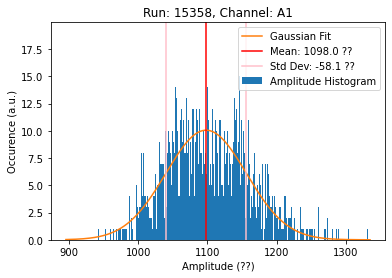

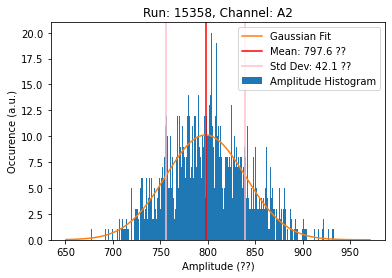

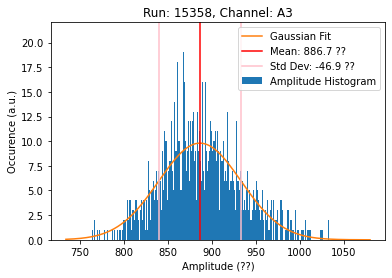

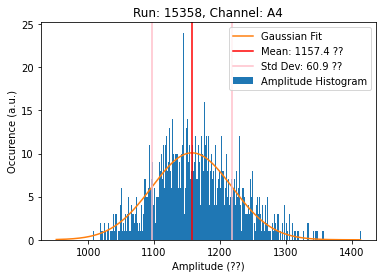

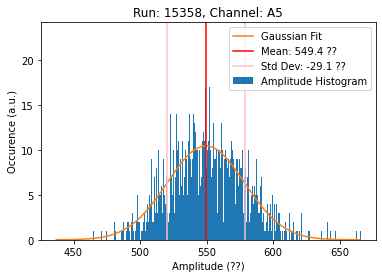

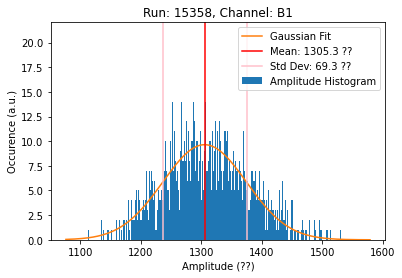

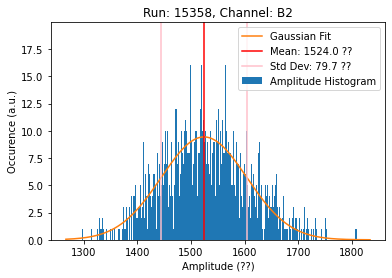

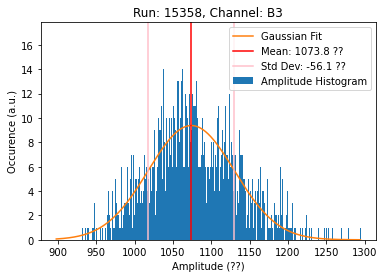

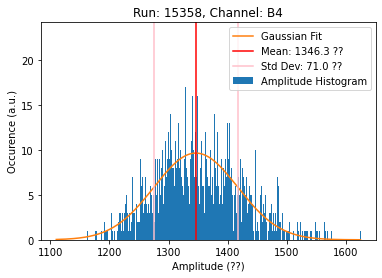

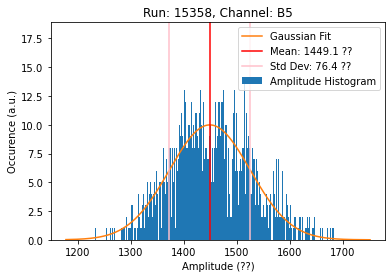

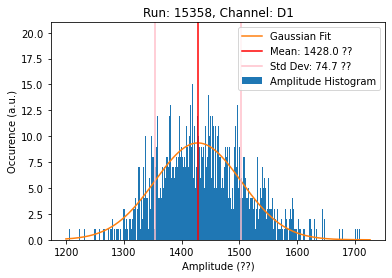

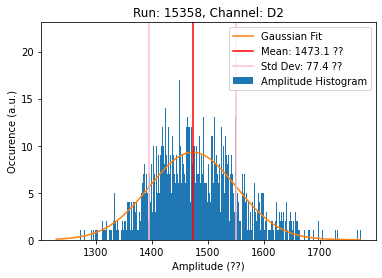

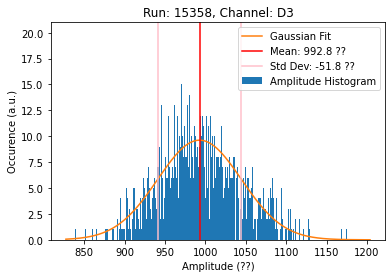

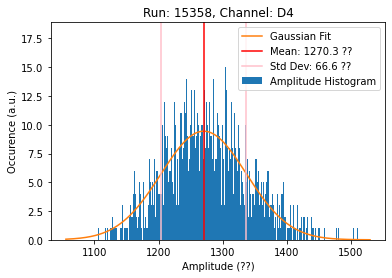

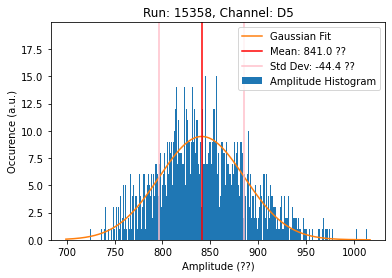

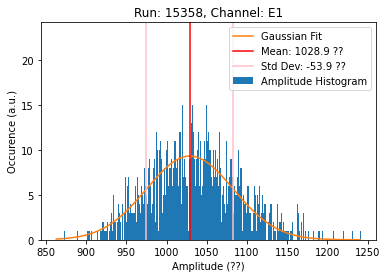

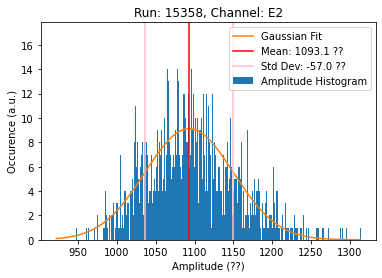

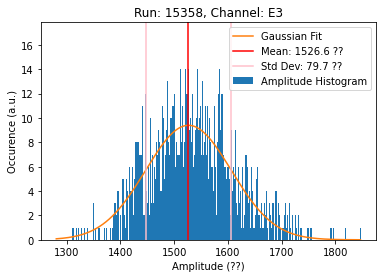

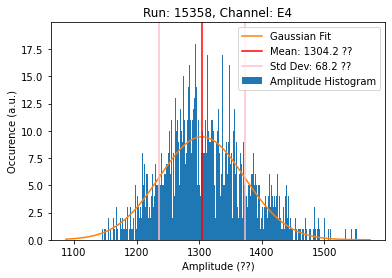

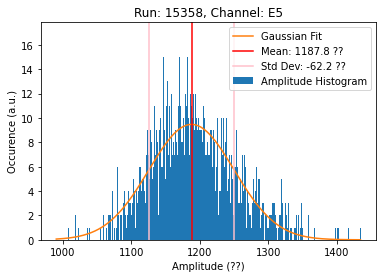

-- Histogram plot(s) finished --


In [3]:
test1.run_amplitude()

Run:  15358  Split:  Merged


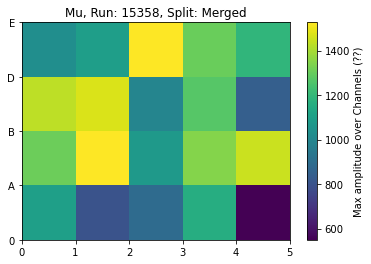

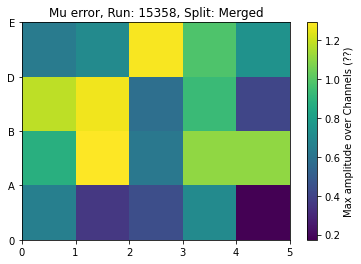

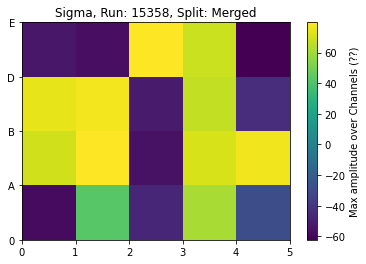

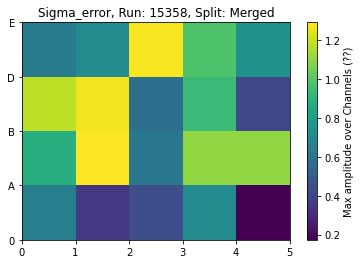

-- Colormesh plot(s) finished --


<Figure size 432x288 with 0 Axes>

In [5]:
test1.run_statistics()

In [ ]:
# TODO: evolution per spill

### I.1.b for a list of runs

In [7]:
test2 = Amplitude([15358, 15359, 15362], ['A', 'B', 'D', 'E'])

Run:  15358  Split:  Merged


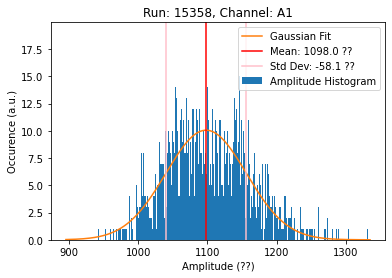

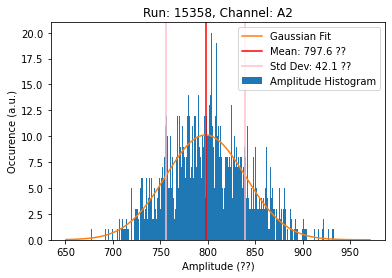

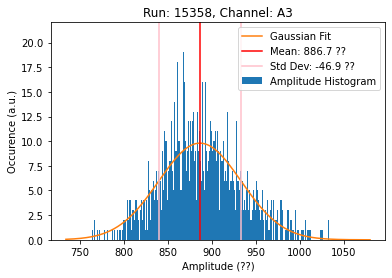

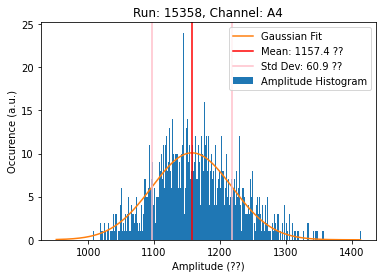

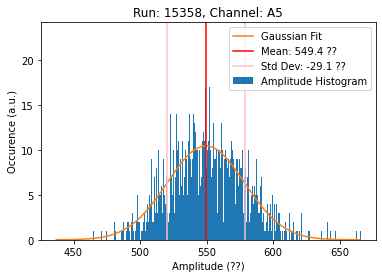

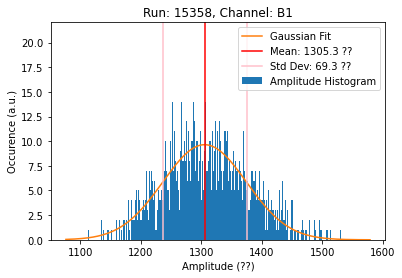

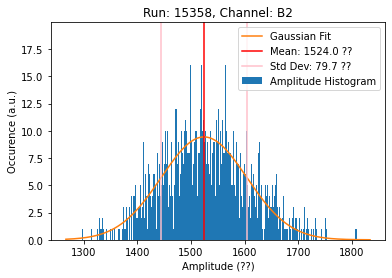

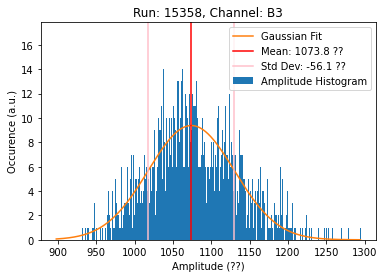

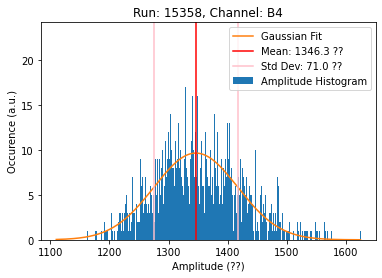

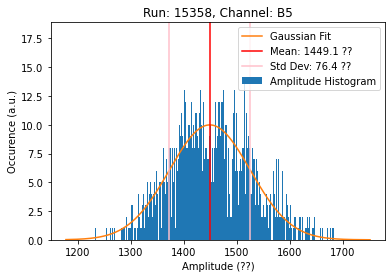

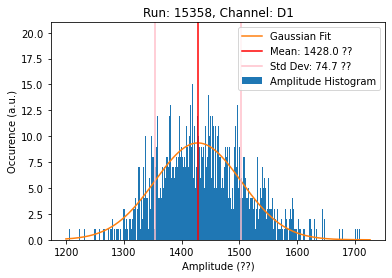

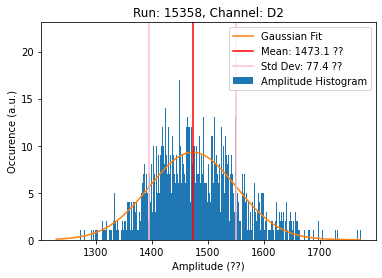

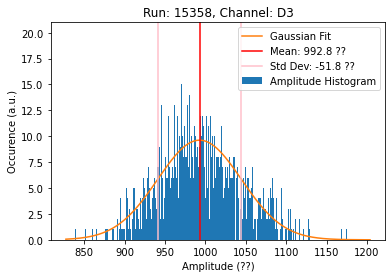

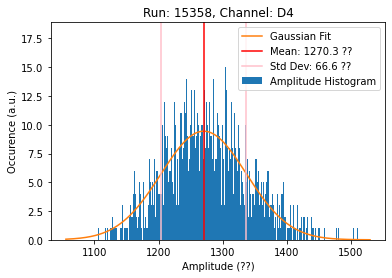

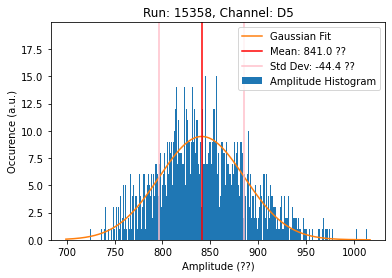

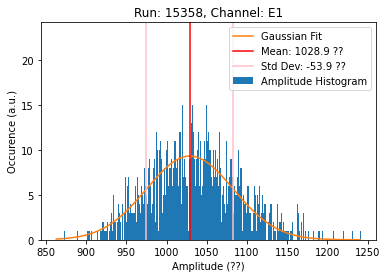

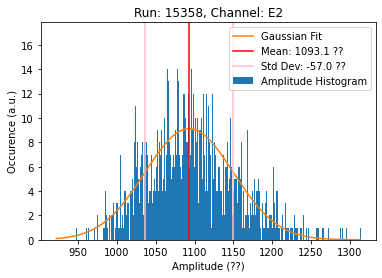

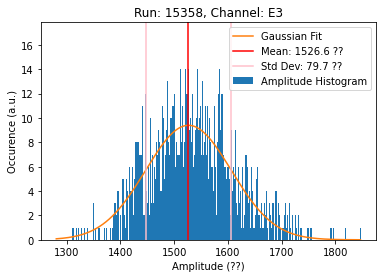

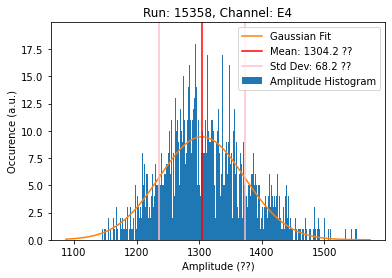

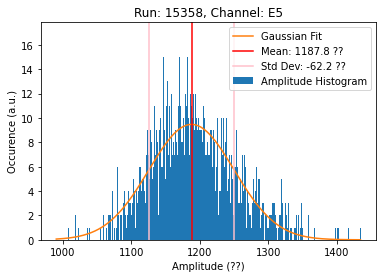

Run:  15359  Split:  Merged


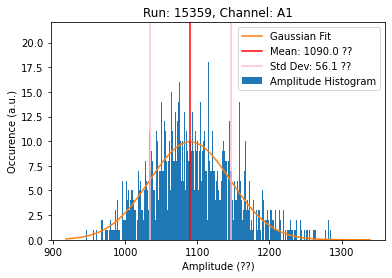

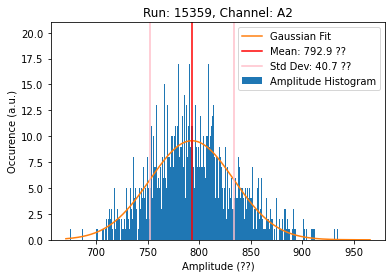

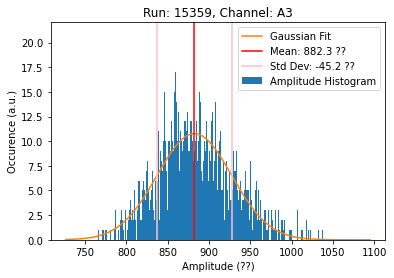

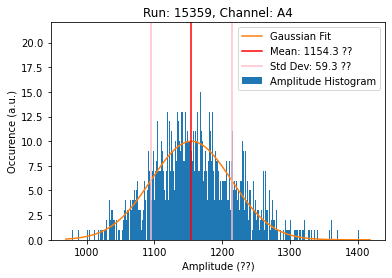

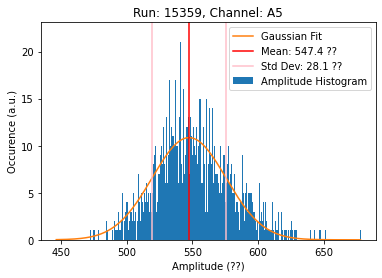

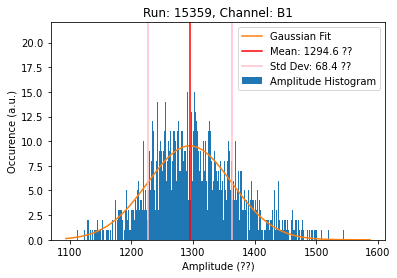

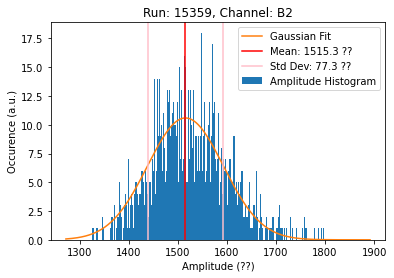

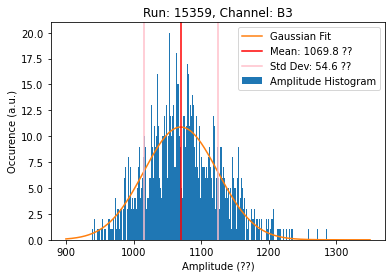

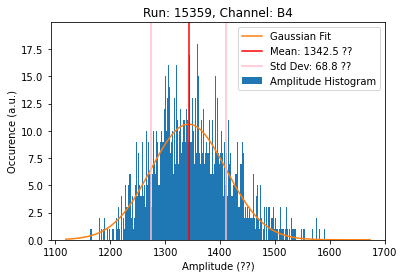

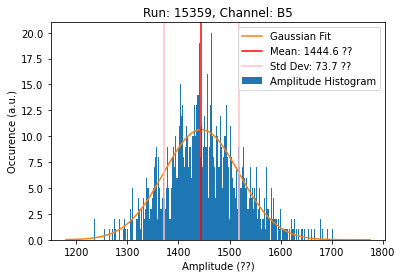

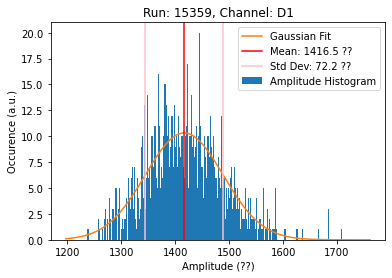

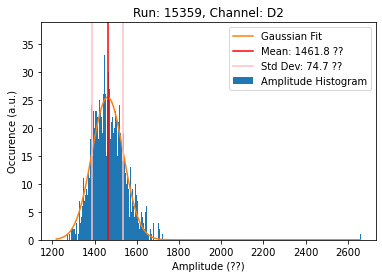

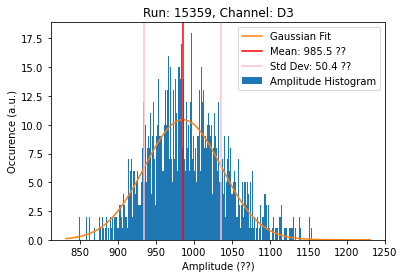

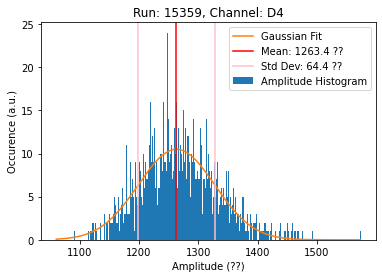

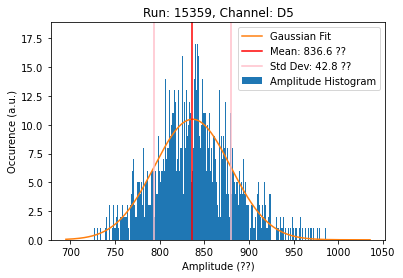

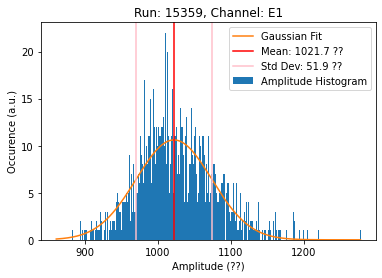

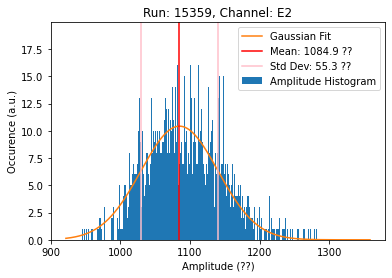

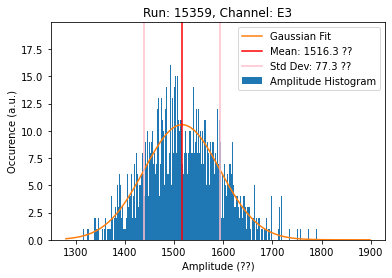

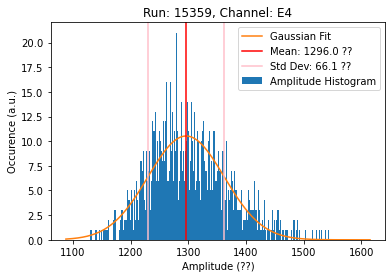

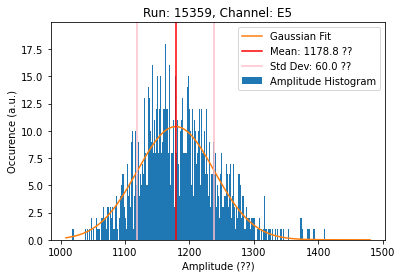

Run:  15362  Split:  Merged


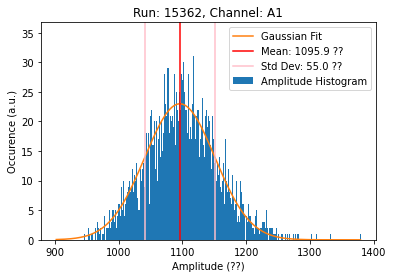

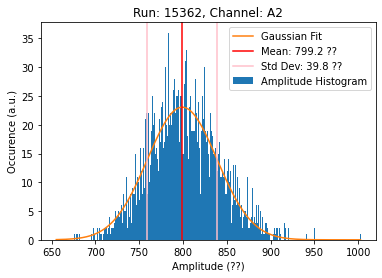

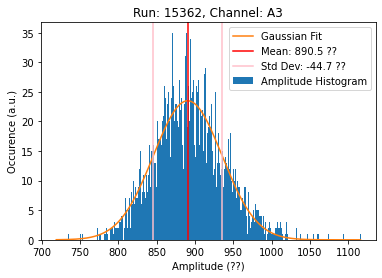

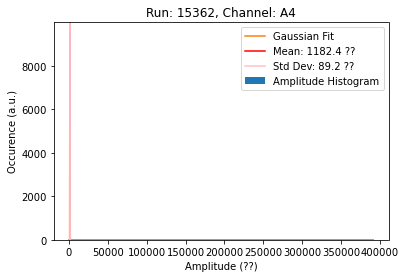

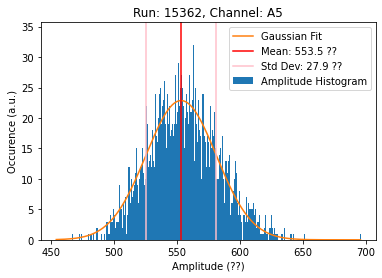

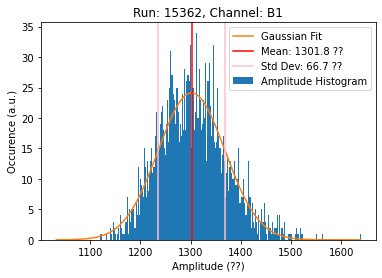

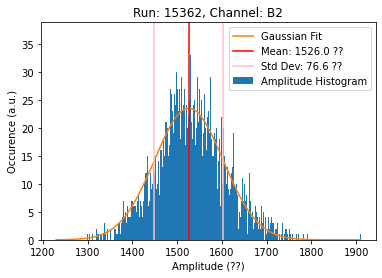

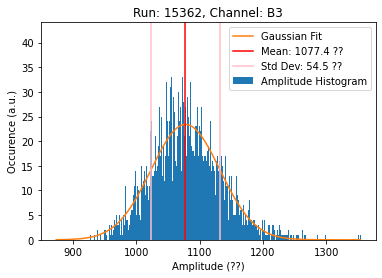

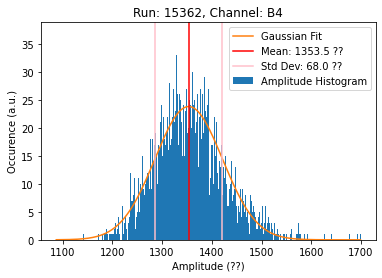

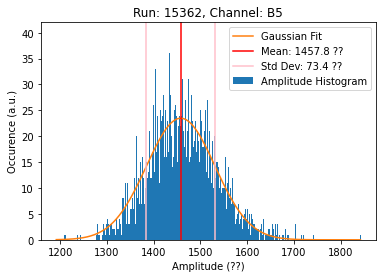

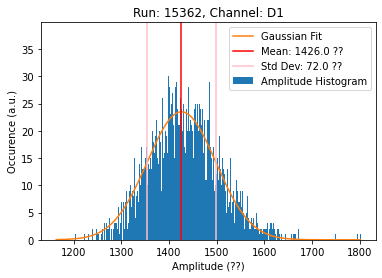

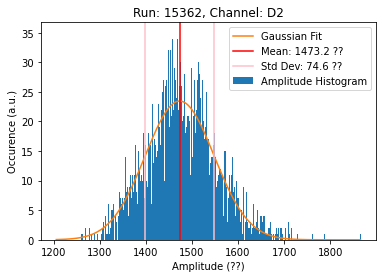

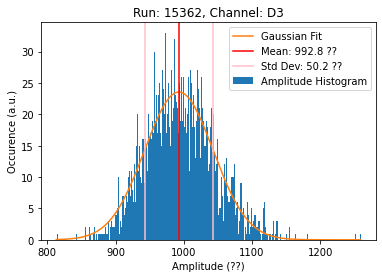

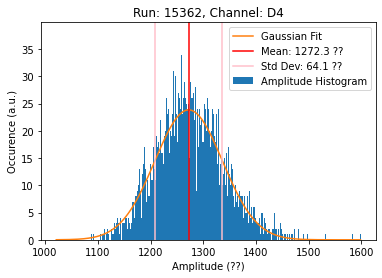

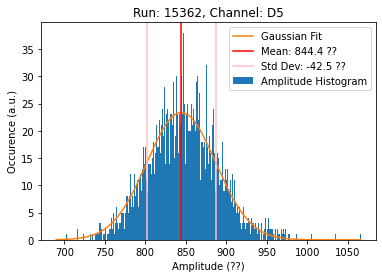

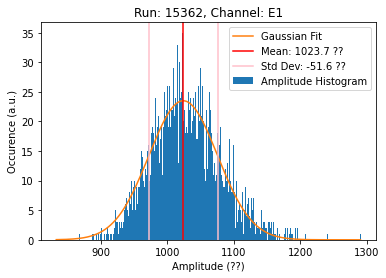

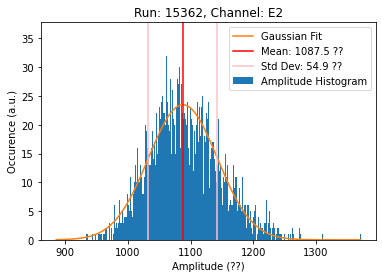

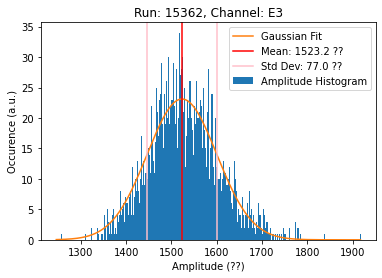

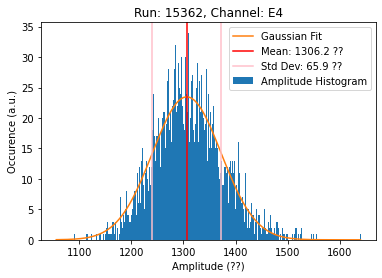

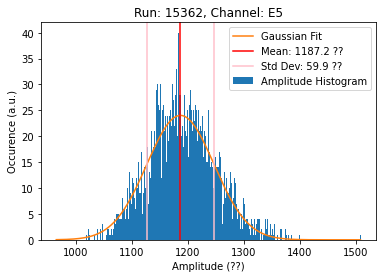

-- Histogram plot(s) finished --


In [8]:
test2.run_amplitude()

Run:  15358  Split:  Merged


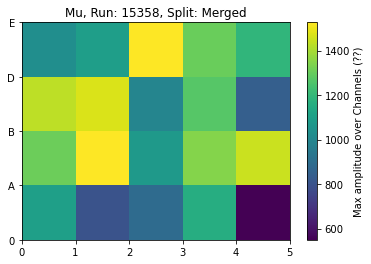

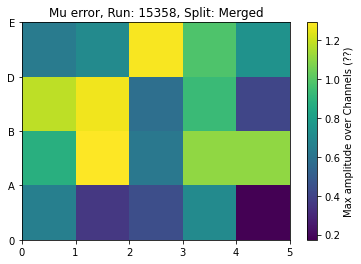

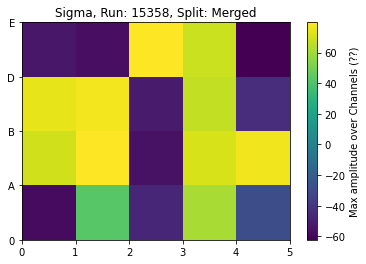

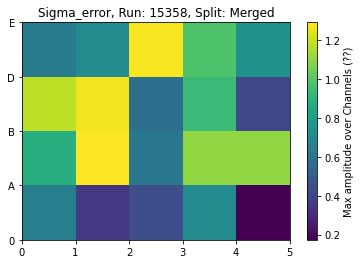

Run:  15359  Split:  Merged


<Figure size 432x288 with 0 Axes>

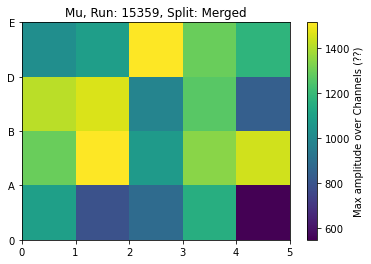

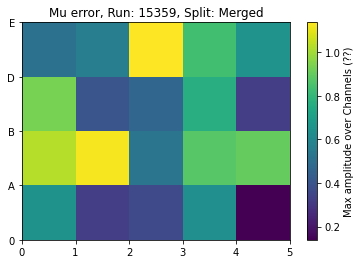

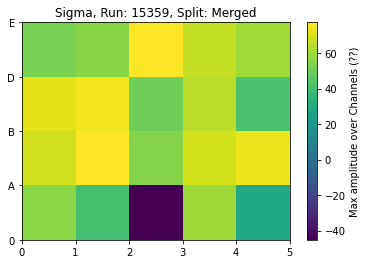

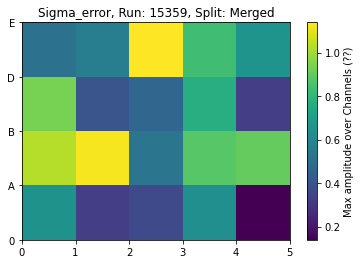

Run:  15362  Split:  Merged


<Figure size 432x288 with 0 Axes>

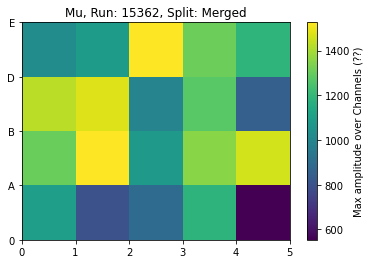

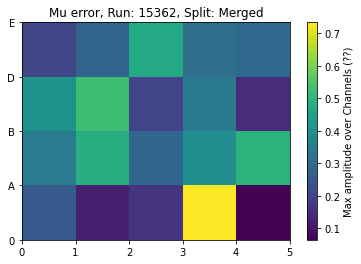

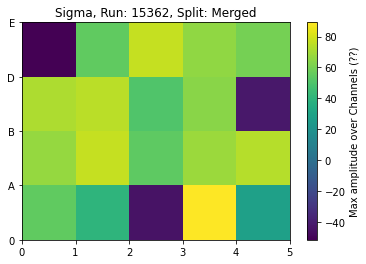

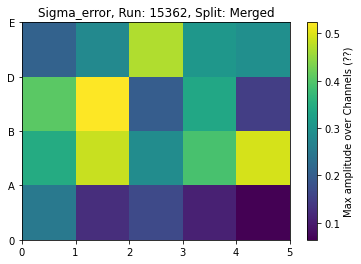

-- Colormesh plot(s) finished --


<Figure size 432x288 with 0 Axes>

In [9]:
test2.run_statistics()

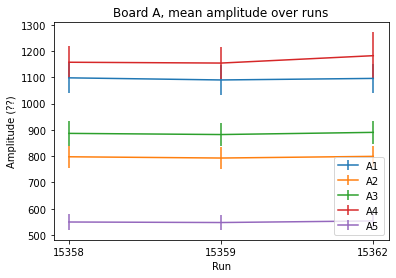

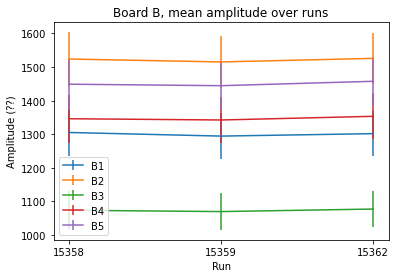

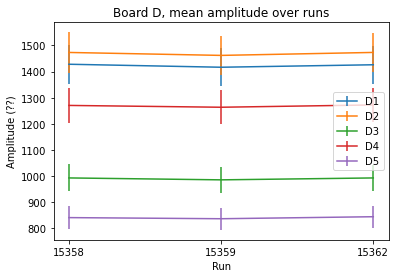

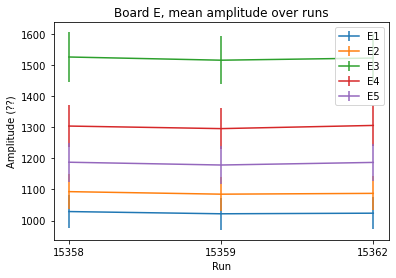

In [10]:
test2.variation_plot_runs()

## I.2 With the data from June 2022, with the board ['C'] working at the time

### I.2.a for a single run

In [11]:
test3 = Amplitude([15610], ['C'])

Run:  15610  Split:  Merged


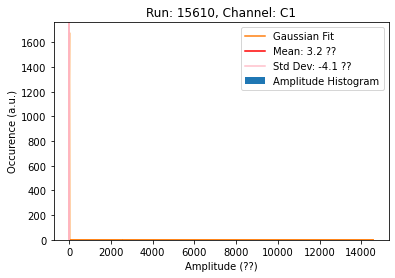

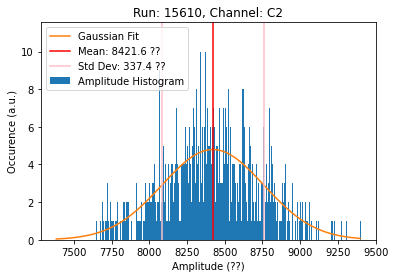

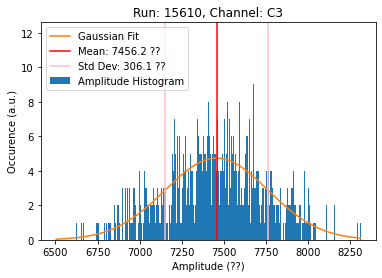

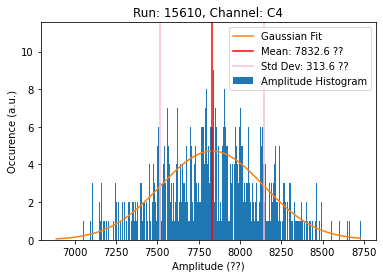

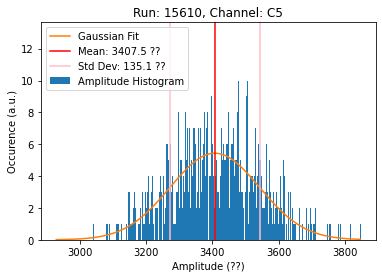

-- Histogram plot(s) finished --


In [12]:
test3.run_amplitude()

Run:  15610  Split:  Merged


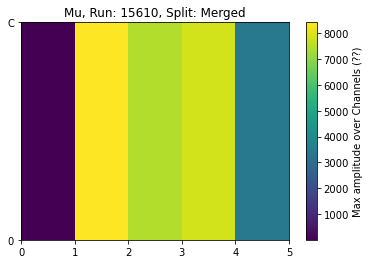

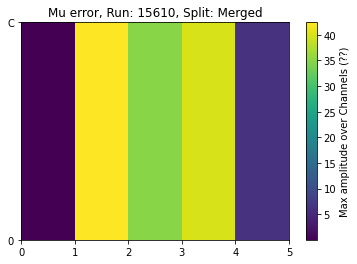

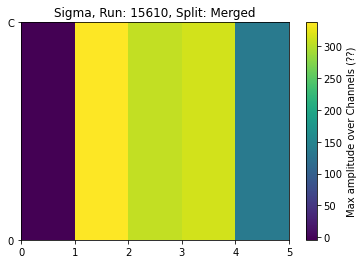

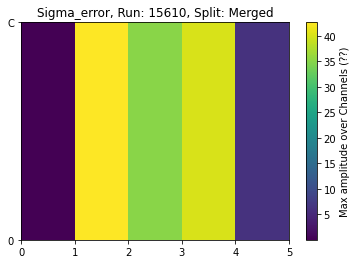

-- Colormesh plot(s) finished --


<Figure size 432x288 with 0 Axes>

In [13]:
test3.run_statistics()

### I.2.b for a list of runs

In [14]:
test4 = Amplitude([15610, 15611, 15612], ['C'])

Run:  15610  Split:  Merged


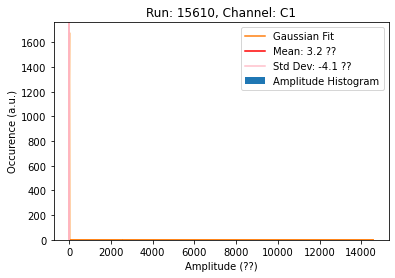

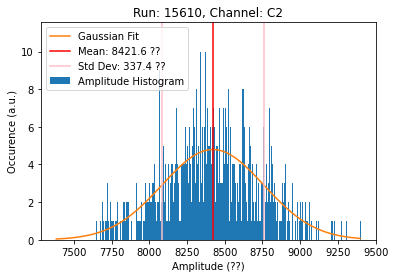

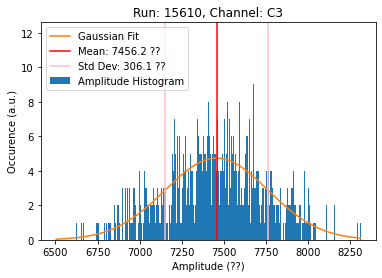

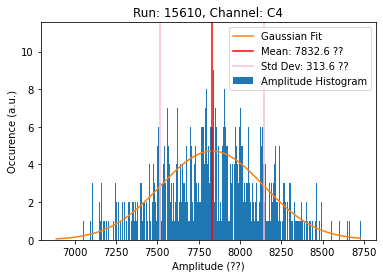

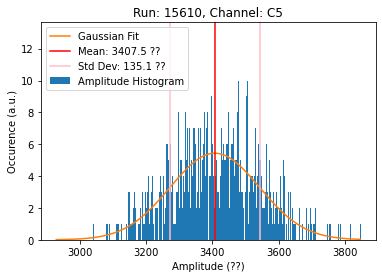

Run:  15611  Split:  Merged


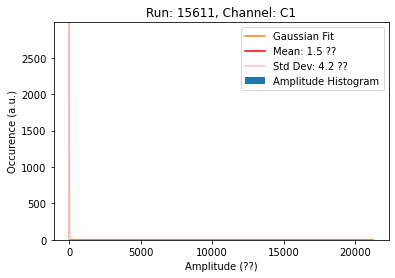

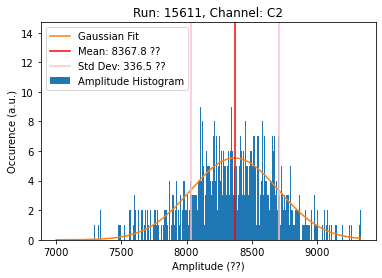

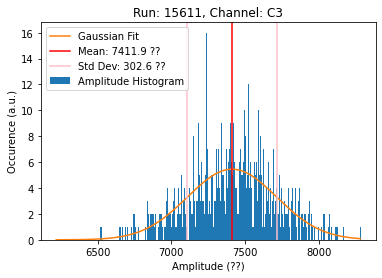

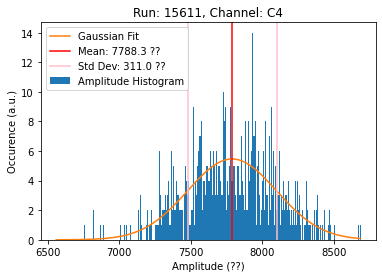

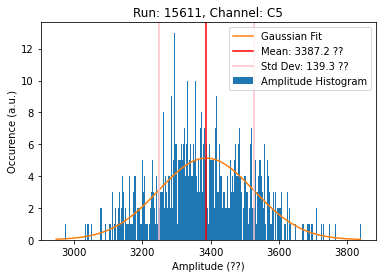

Run:  15612  Split:  Merged


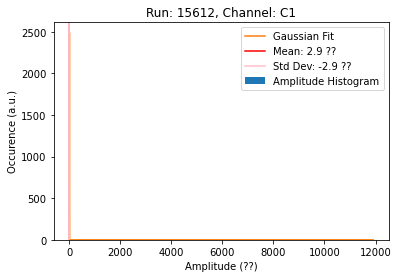

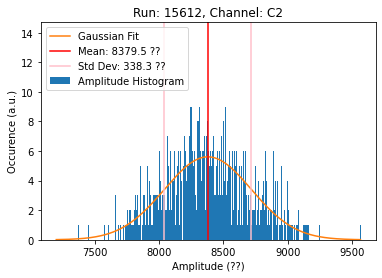

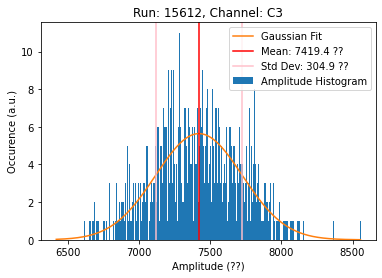

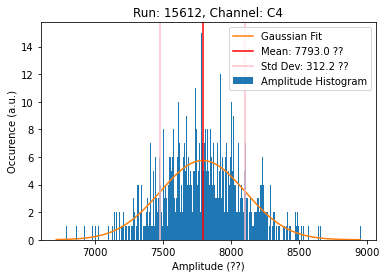

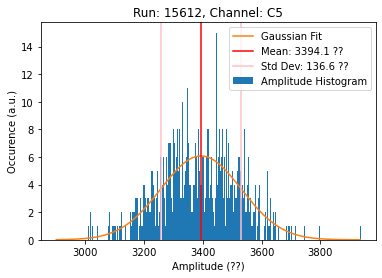

-- Histogram plot(s) finished --


In [15]:
test4.run_amplitude()

Run:  15610  Split:  Merged


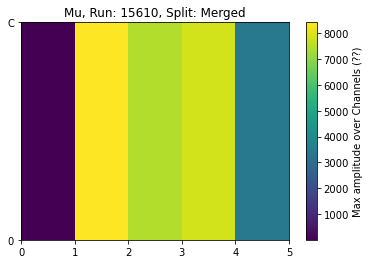

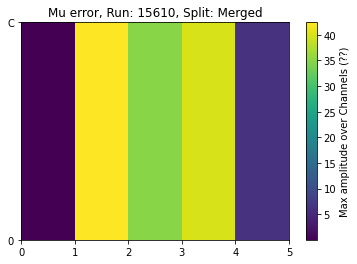

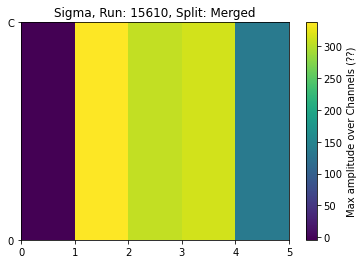

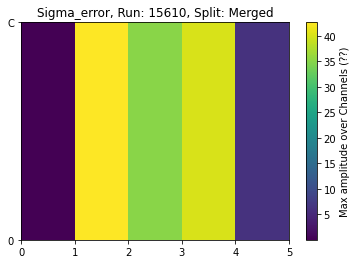

Run:  15611  Split:  Merged


<Figure size 432x288 with 0 Axes>

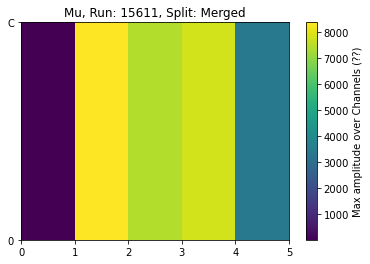

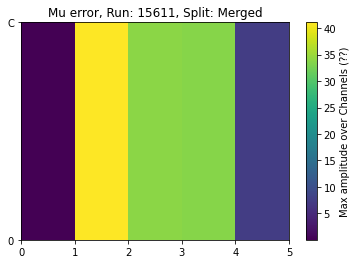

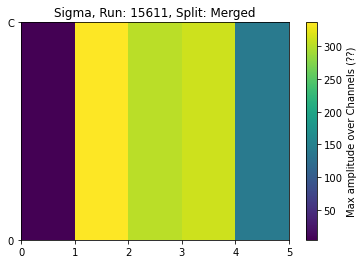

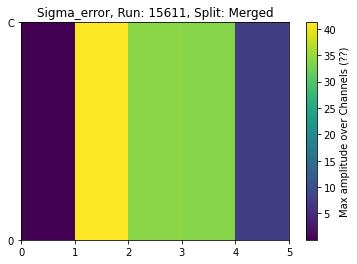

Run:  15612  Split:  Merged


<Figure size 432x288 with 0 Axes>

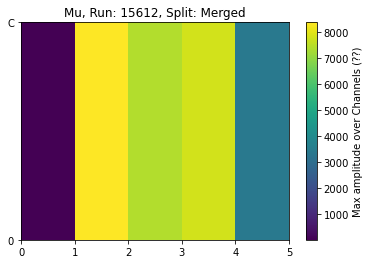

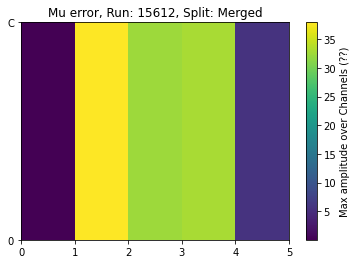

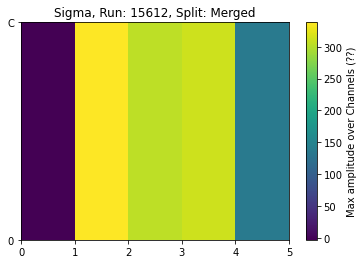

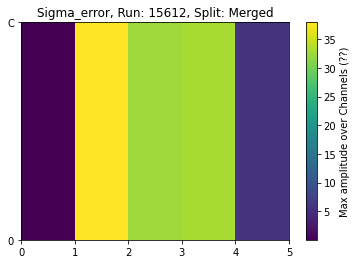

-- Colormesh plot(s) finished --


<Figure size 432x288 with 0 Axes>

In [16]:
test4.run_statistics()

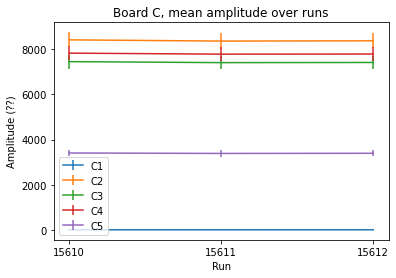

In [17]:
test4.variation_plot_runs()

# II. Time resolution

## II.1 With the data from January 2022, with the boards ['A', 'B', 'D', 'E'] working at the time

### II.1.a for a single run

In [2]:
test5 = Time([15500], ['A', 'B', 'D', 'E'])

Run:  15500  Split:  Merged


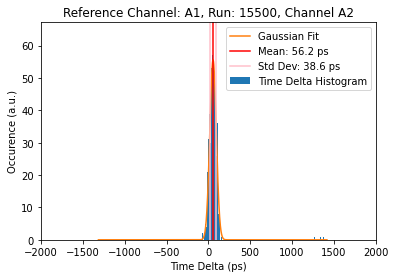

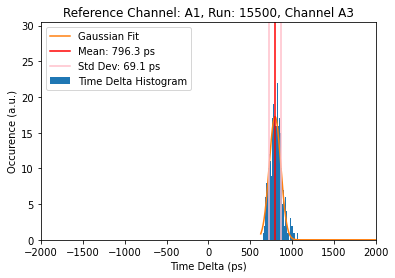

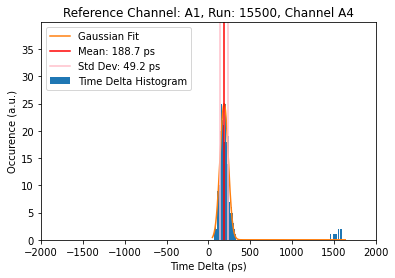

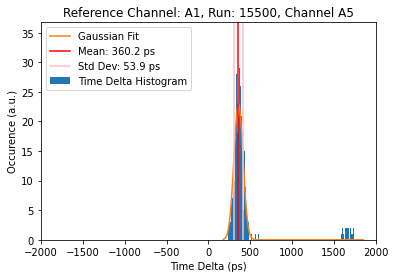

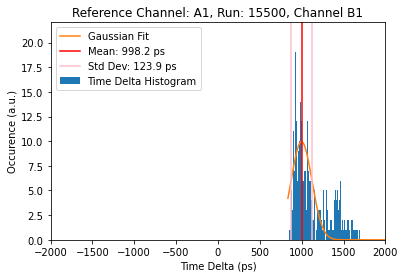

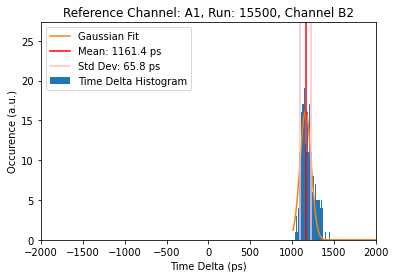

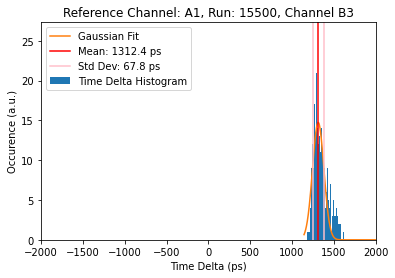

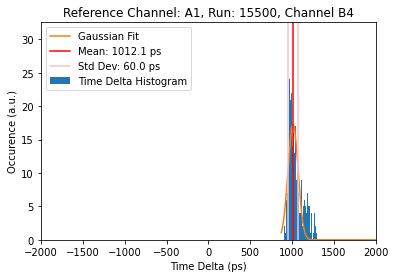

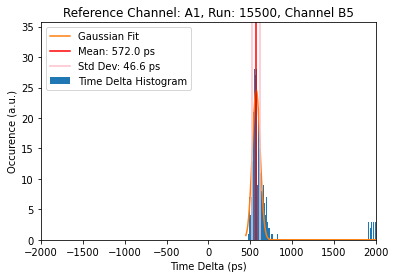

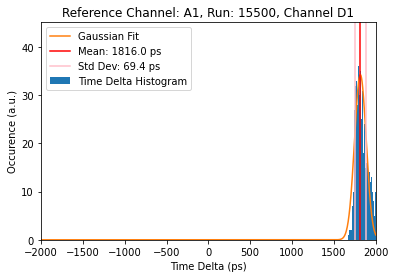

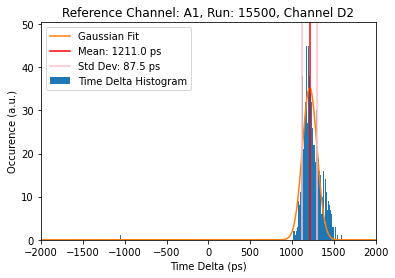

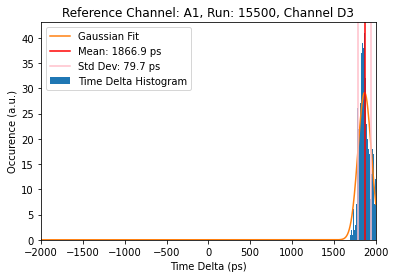

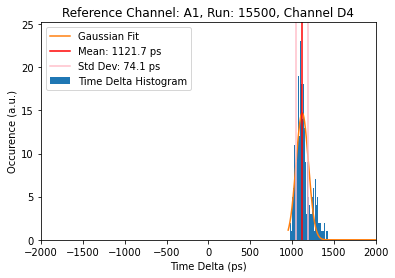

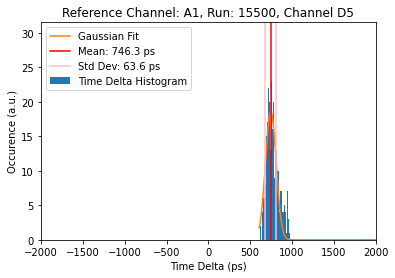

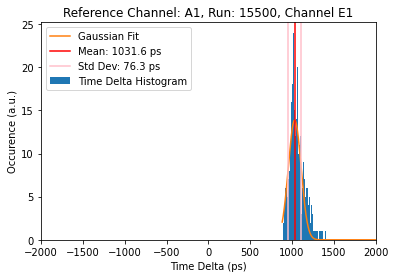

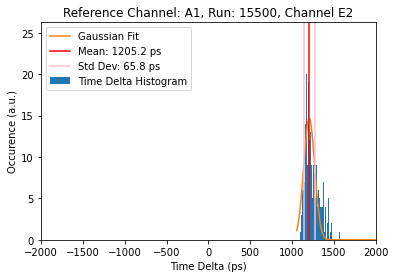

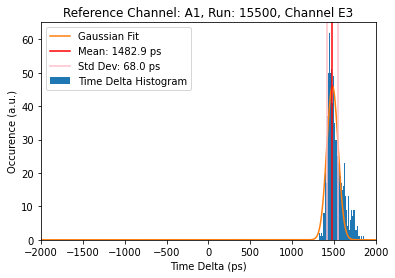

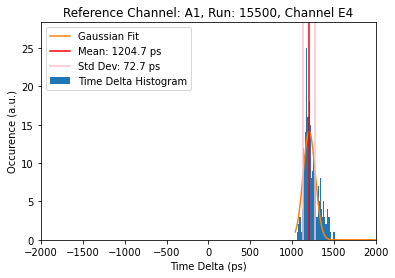

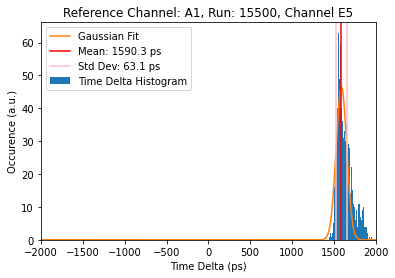

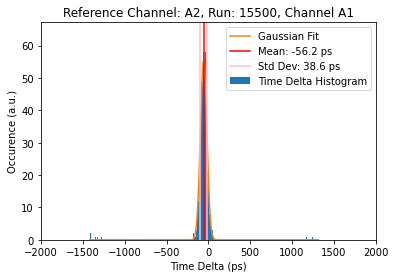

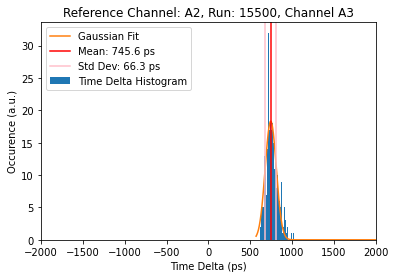

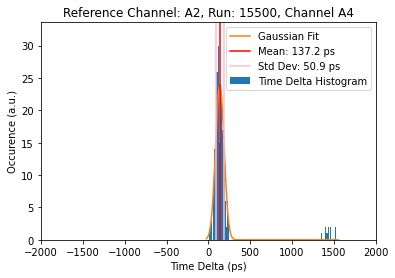

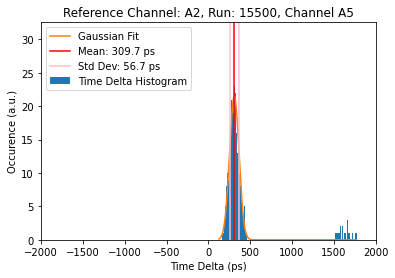

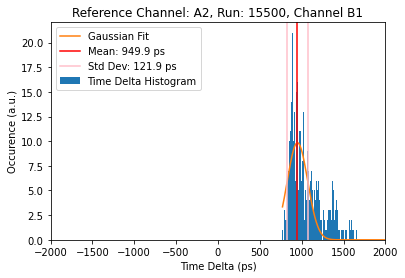

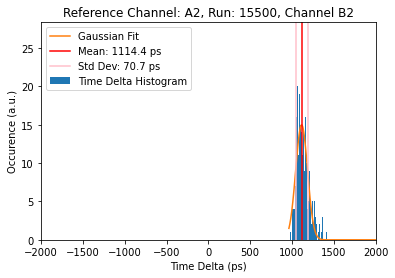

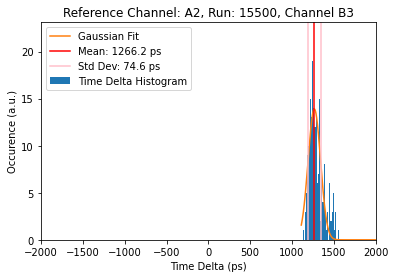

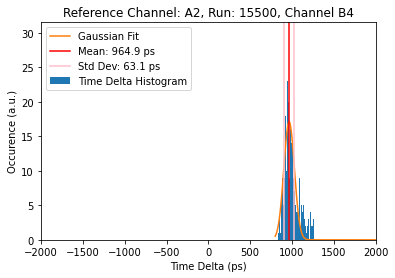

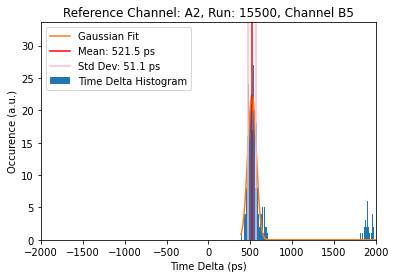

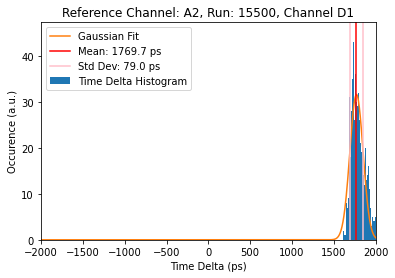

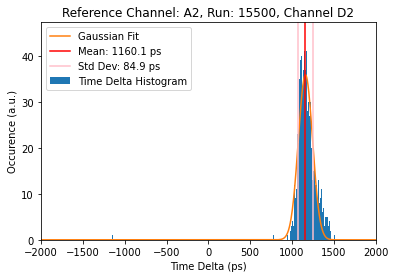

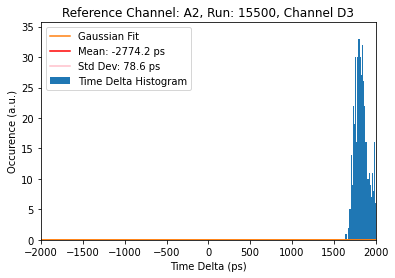

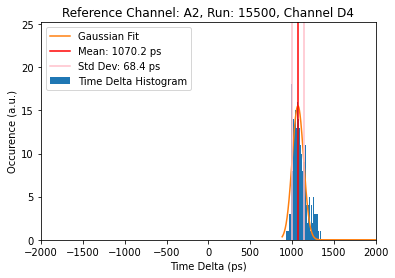

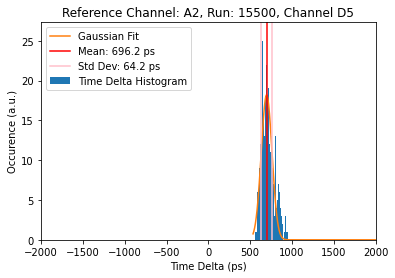

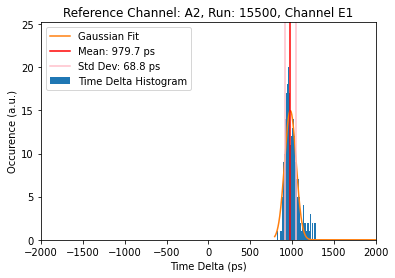

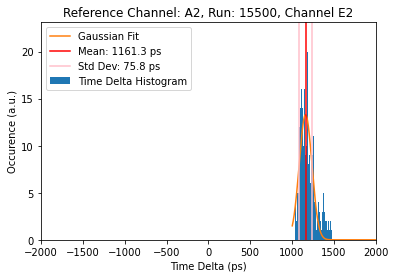

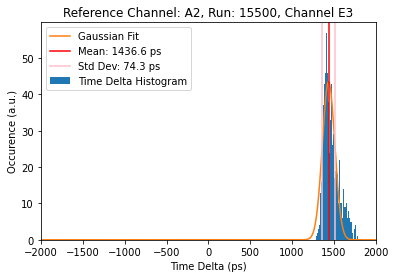

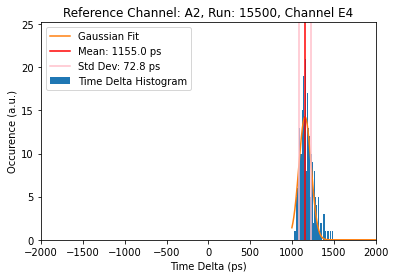

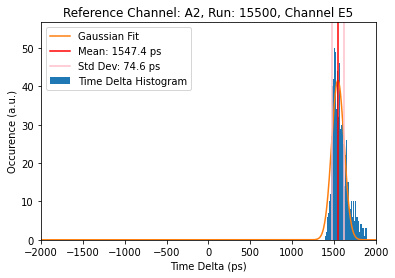

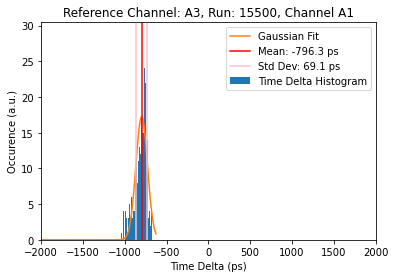

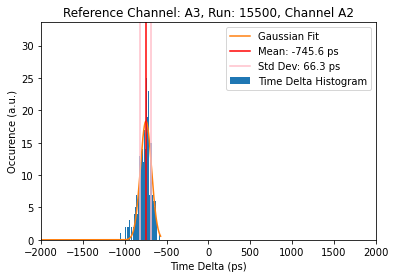

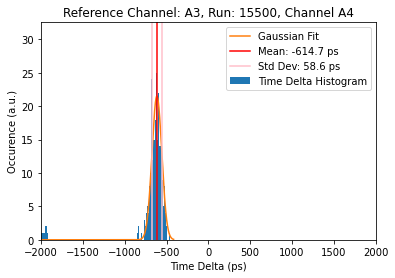

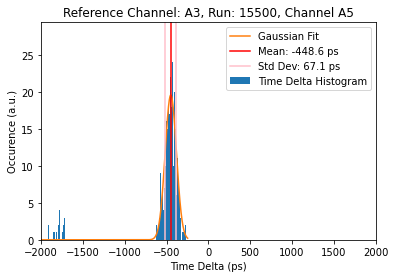

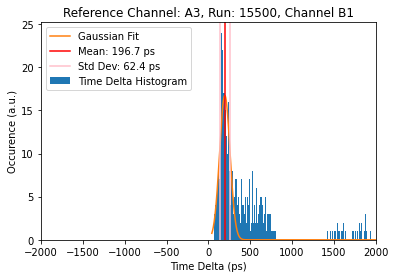

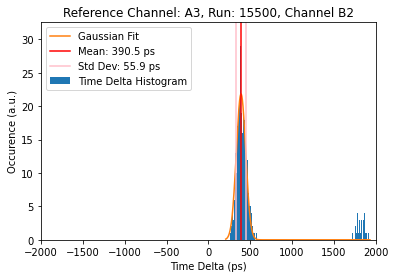

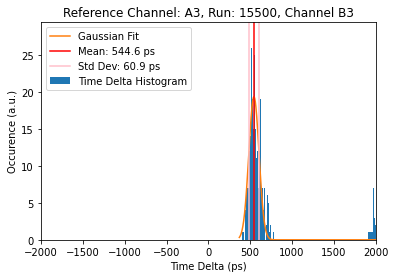

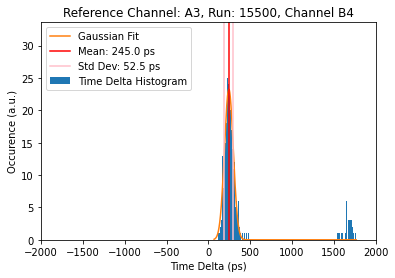

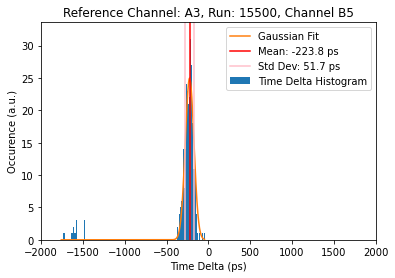

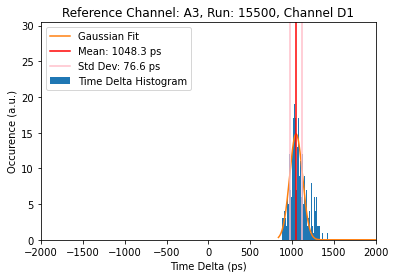

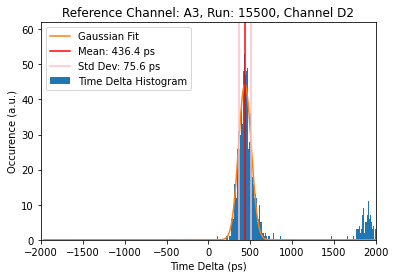

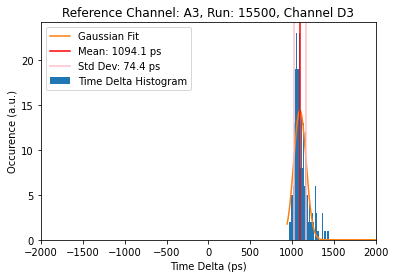

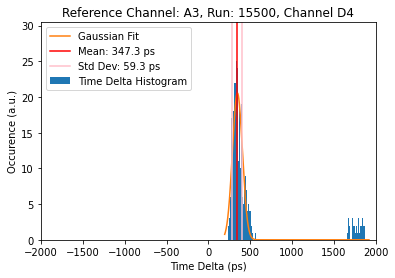

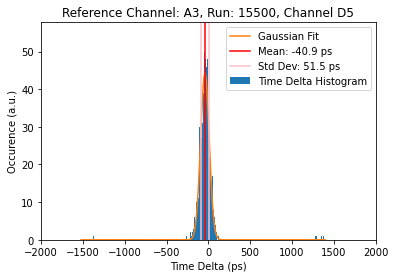

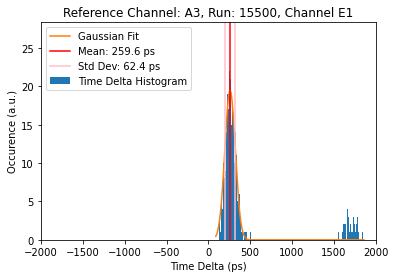

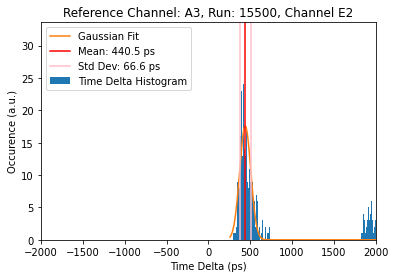

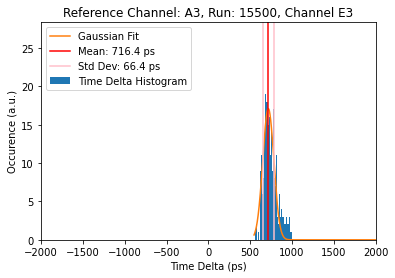

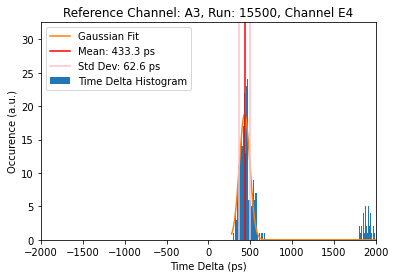

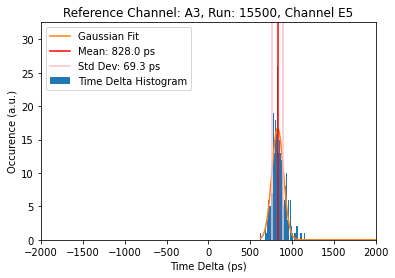

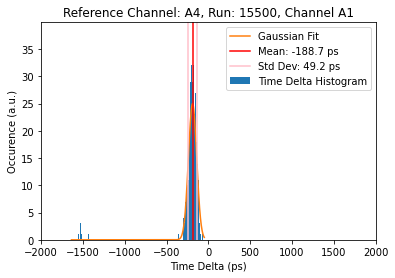

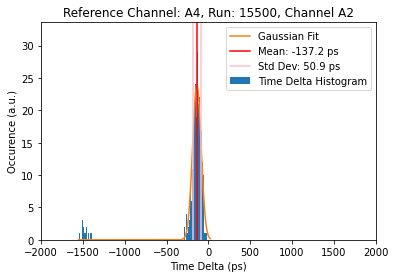

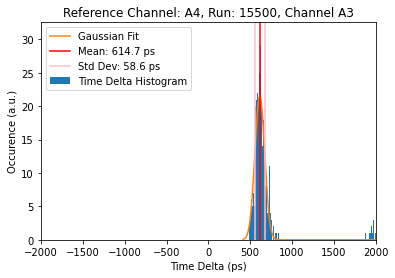

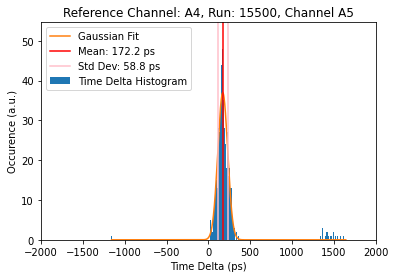

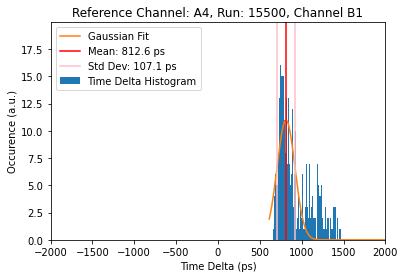

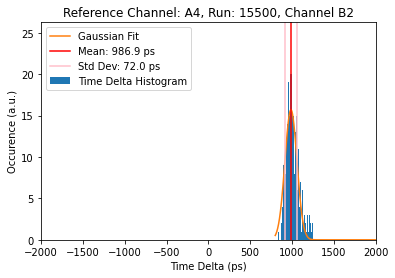

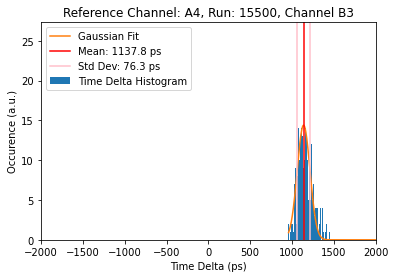

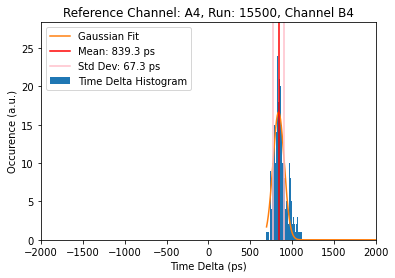

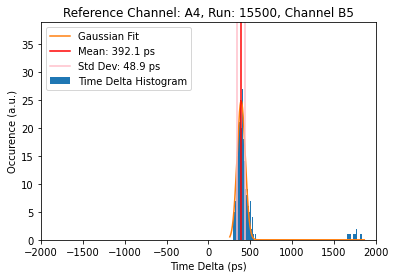

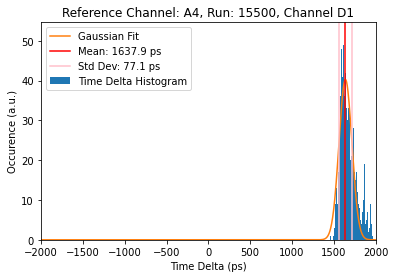

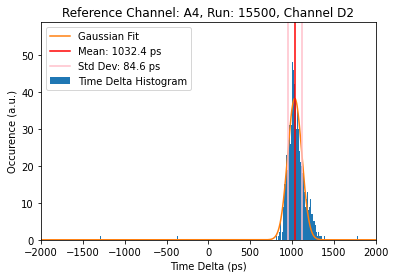

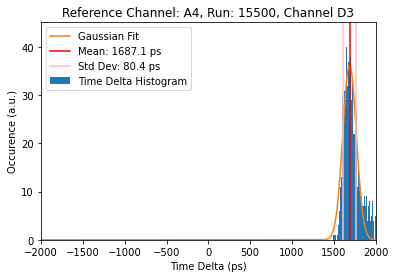

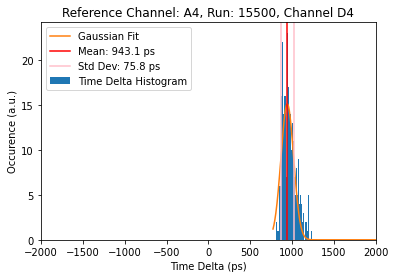

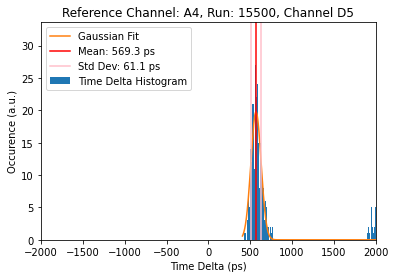

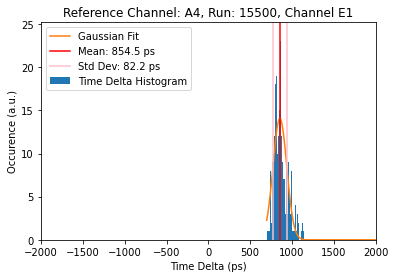

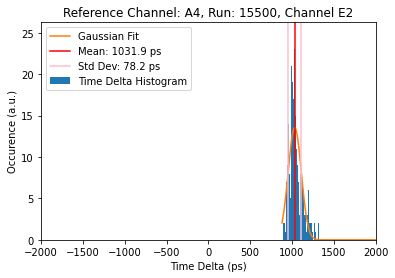

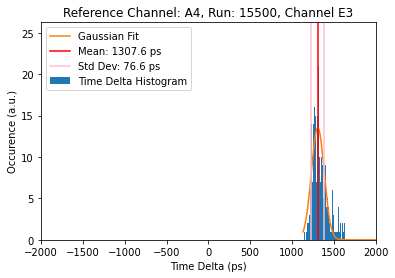

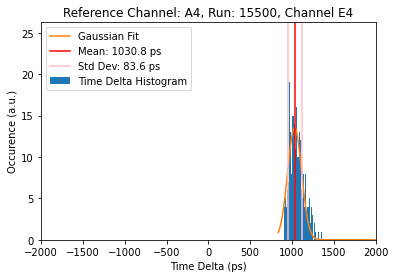

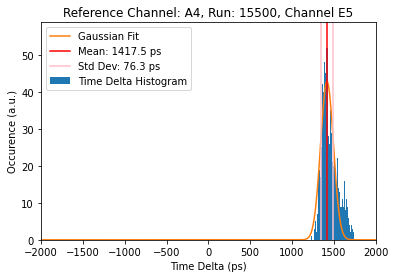

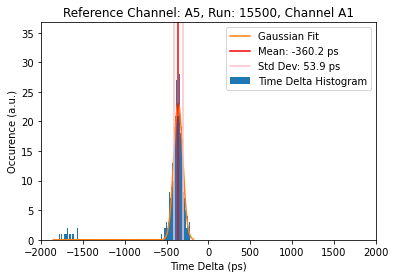

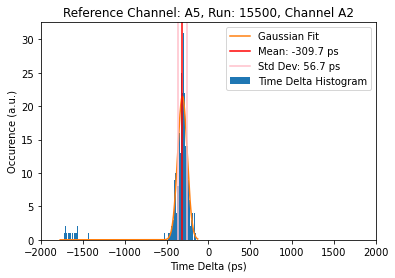

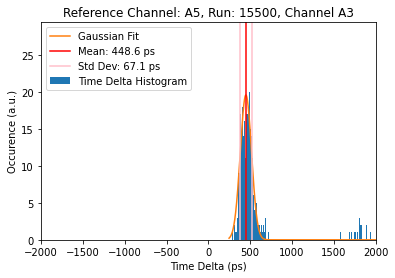

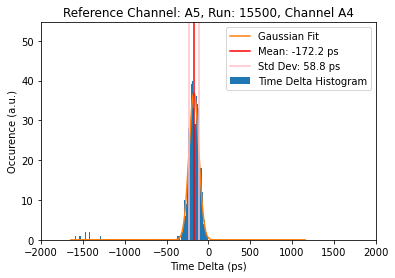

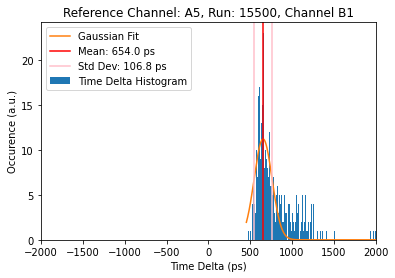

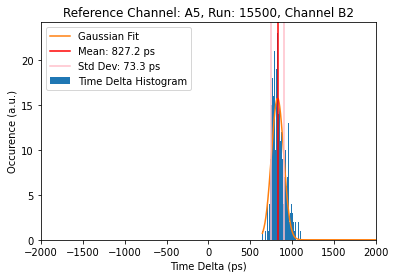

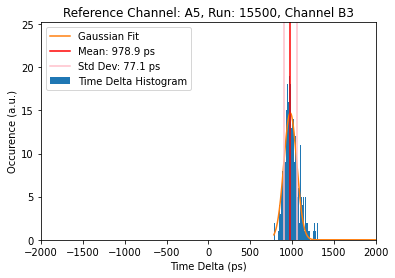

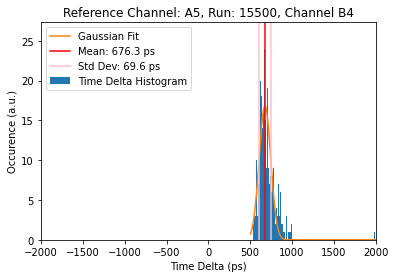

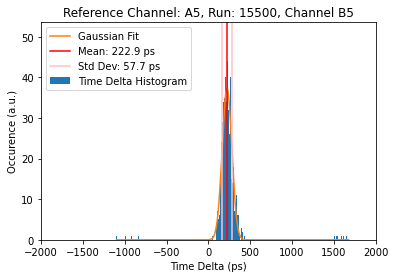

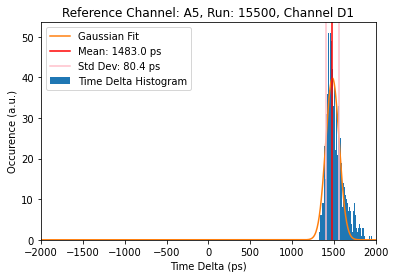

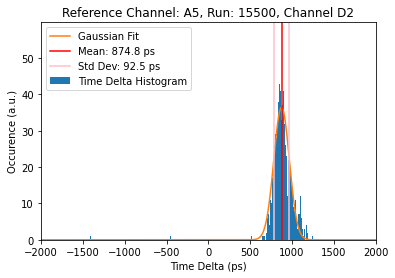

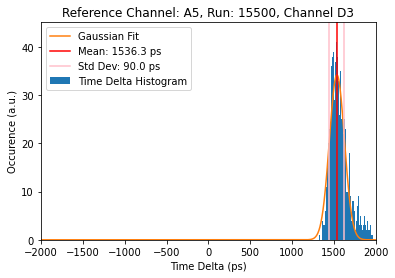

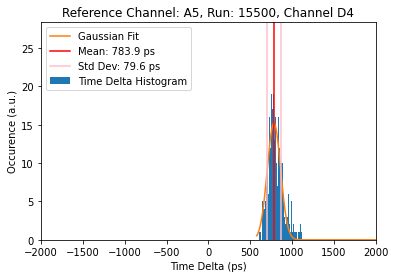

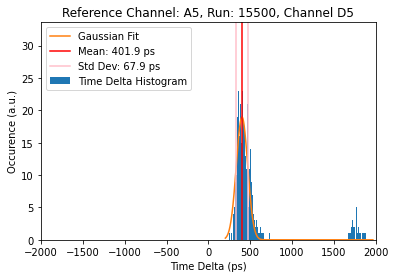

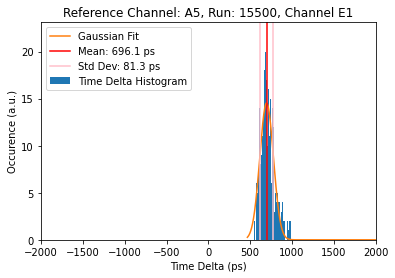

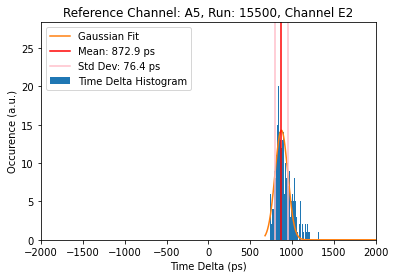

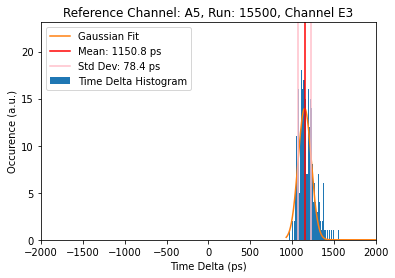

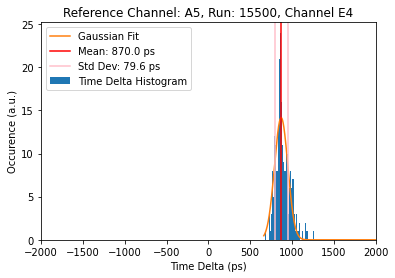

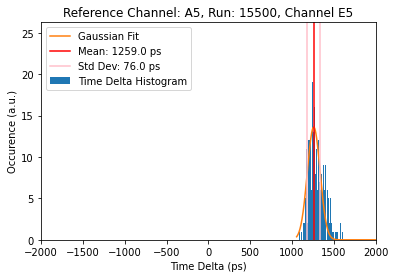

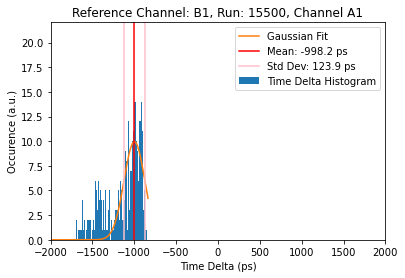

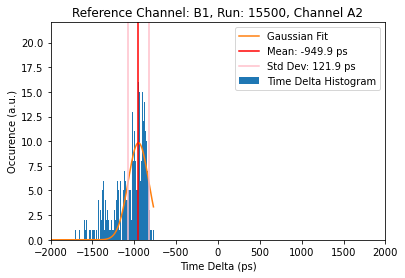

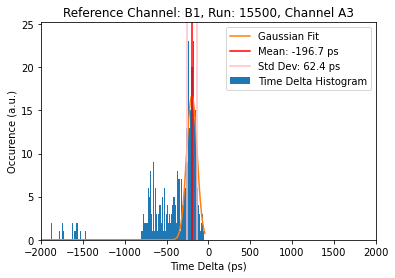

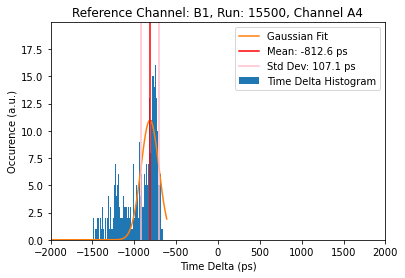

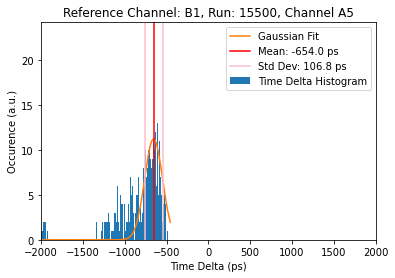

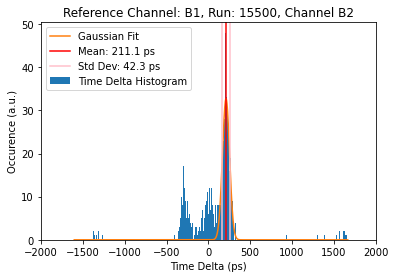

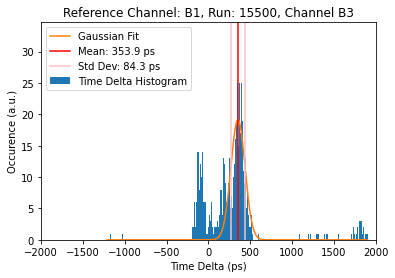

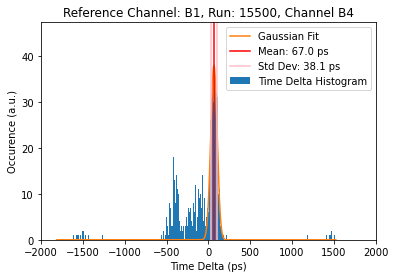

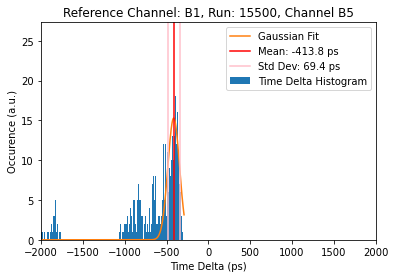

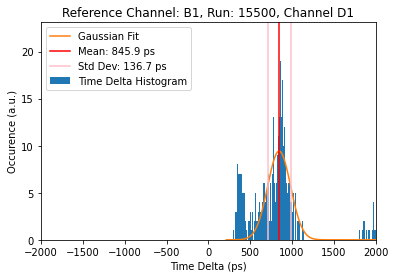

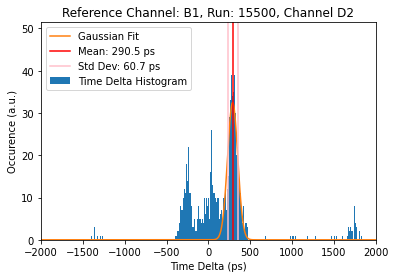

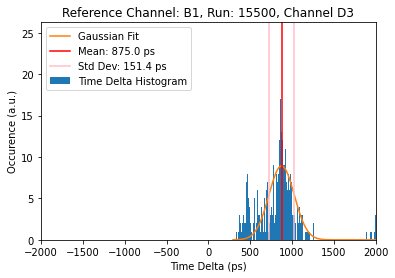

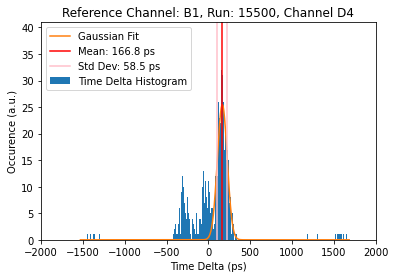

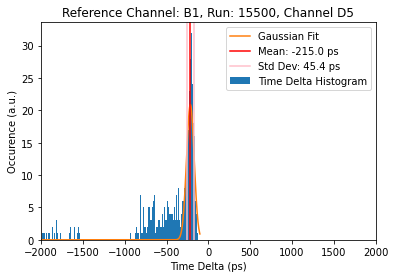

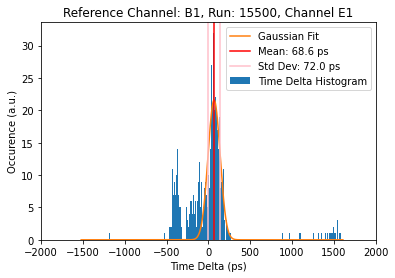

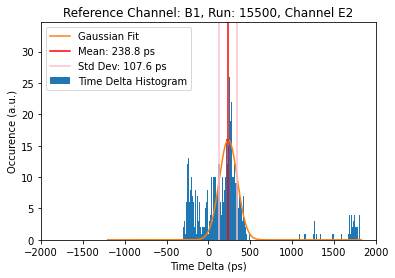

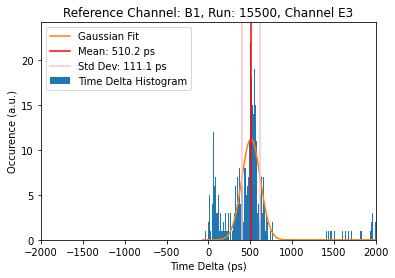

In [ ]:
test5.run_time_delta()

In [ ]:
test5.run_statistics()

### II.1.b for a list of runs

In [41]:
test6 = Time([15358, 15359], ['A', 'B', 'D', 'E'])

Run:  15358  Split:  Merged


KeyboardInterrupt: 

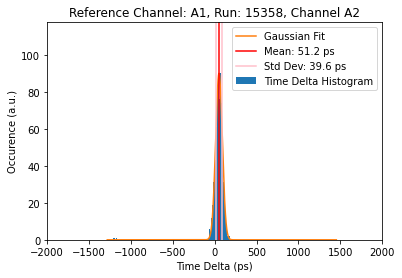

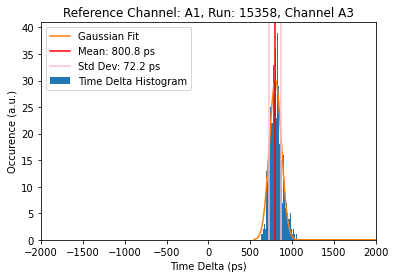

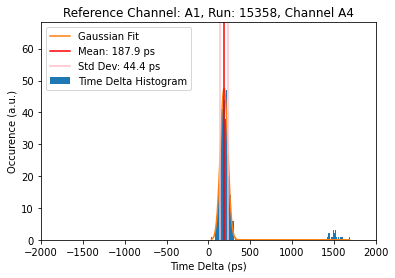

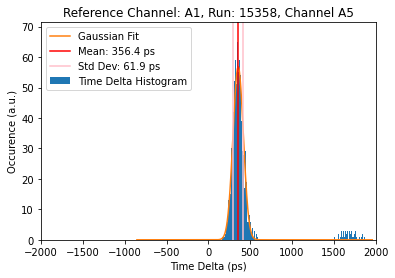

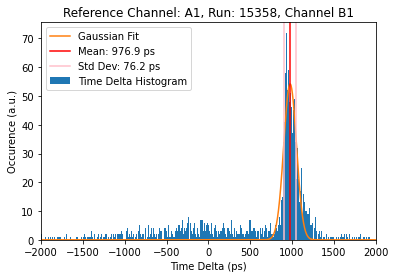

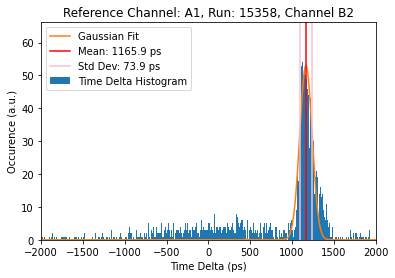

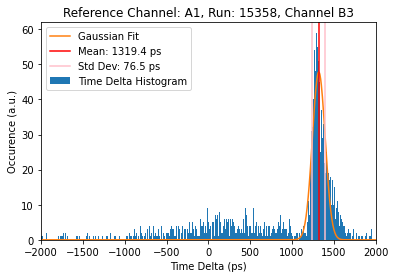

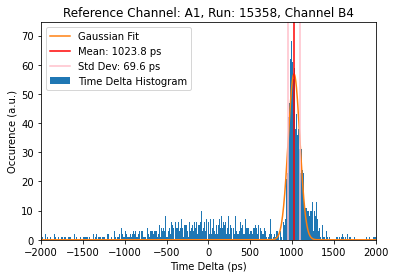

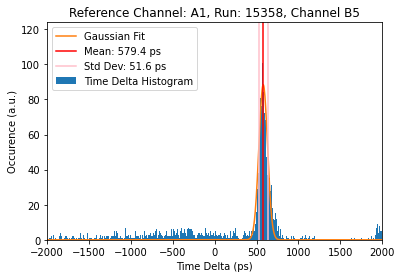

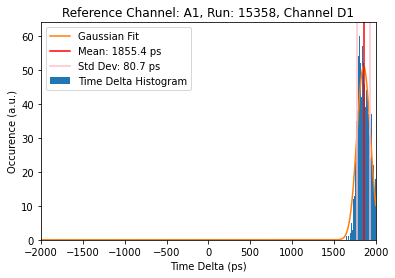

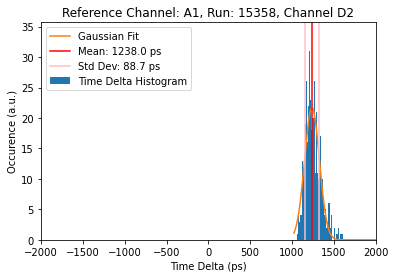

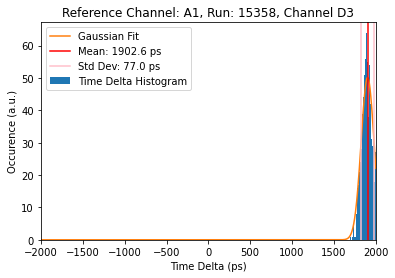

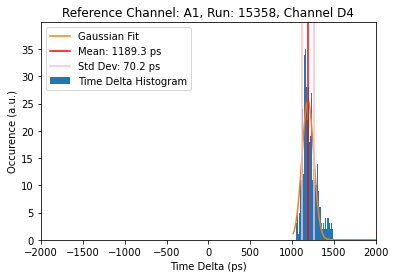

Error in callback <function flush_figures at 0x7f61e69aa820> (for post_execute):


KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f61e6a17310> (for post_execute):


KeyboardInterrupt: 

In [42]:
test6.run_time_delta()

In [ ]:
test6.run_statistics()

In [ ]:
# TODO: finish these statistics
# test6.variation_plot_runs()

## II.2 with the data from June 2022, with the board ['C'] working at the time

### II.2.a for a single run

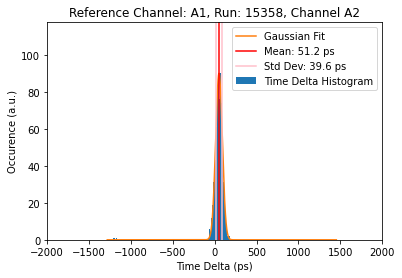

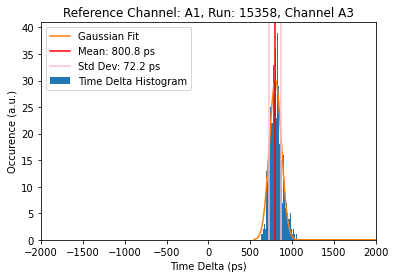

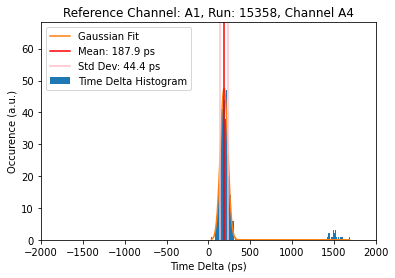

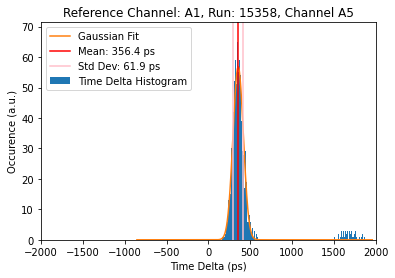

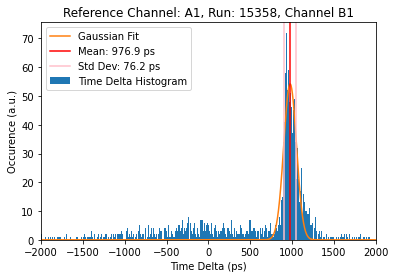

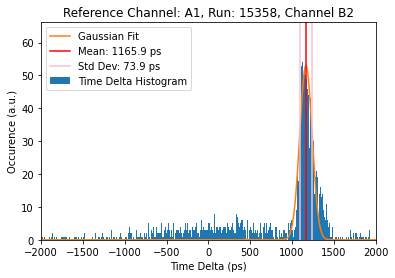

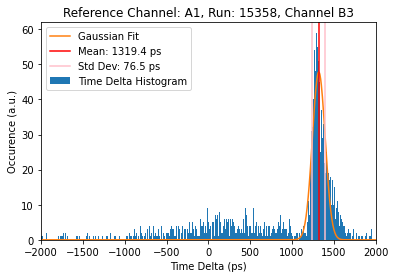

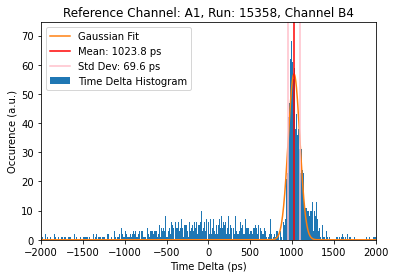

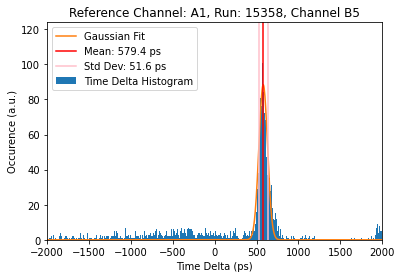

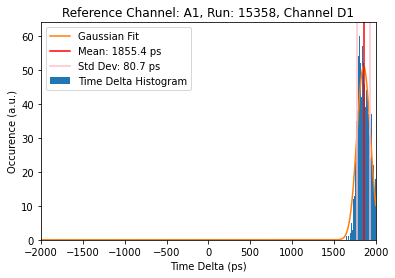

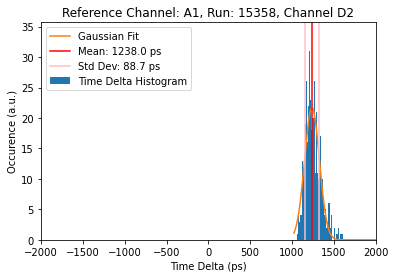

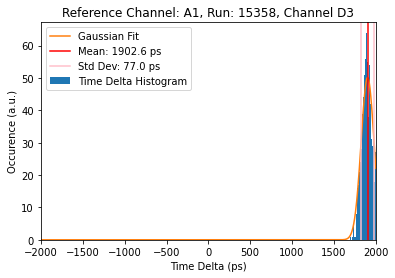

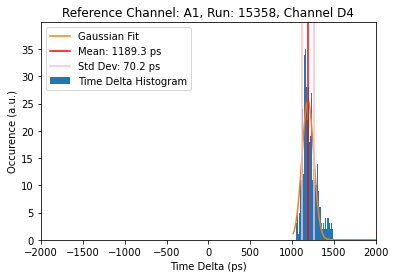

Error in callback <function flush_figures at 0x7f61e69aa820> (for post_execute):


KeyboardInterrupt: 

In [43]:
test7 = Time([15610], ['C'])

In [ ]:
test7.run_amplitude()

In [ ]:
test7.run_statistics()

### II.2.b for a list of runs

In [ ]:
test8 = Time([15610, 15611], ['C'])

In [ ]:
test8.run_amplitude()

In [ ]:
test8.run_statistics()

In [ ]:
# TODO: finish these statistics
# test8.variation_plot_runs()

In [ ]:
# TODO: test8.variation_statistics()